In [1]:
import sys
import ROOT as r
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from array import array as arr

%jsroot on

Welcome to JupyROOT 6.30/02


In [428]:
#fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcV4/mc.root", "READ") #latest full mc processing
#fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/output_nugraphNuE_nugraphScore.root", "READ") #latest mc processing with nugraph scores
fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/output_nugraphNuE_trackScore.root", "READ") #latest mc processing with nugraph scores using trackscore

fData = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/dataV4/data.root", "READ")

fCosmic = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/offbeamData/offbeamV2.root", "READ")

In [3]:
c1 = r.TCanvas("c1", "c1", 800, 600)

h_energy  = fin.Get('cosmic/seqPlots/seqShwContained_rShowerEnergy')
h_dedx = fin.Get('cosmic/seqPlots/seqShwContained_rShowerDeDx')

# h_dedx.Draw()
# c1.Draw()

print(h_energy.GetEntries(), h_dedx.GetEntries())
print(h_energy.Integral(0, h_energy.GetNbinsX()+1), h_dedx.Integral(0, h_dedx.GetNbinsX()+1))
print(h_energy.Integral(), h_dedx.Integral())

h_tnue = fin.Get('allEvents/seqPlots/seqShowerDensity_tNueEnergy')
print(h_tnue.Integral(0, h_tnue.GetNbinsX()+1), h_tnue.GetEntries())

t = fin.Get('t_sel/t_sel')
entries = t.GetEntries()
pot = fin.Get('t_sel').Get('POT').GetBinContent(1)

scale = 3e20 / round(pot, 2)
print(f"Entries: {entries}, POT: {pot}, Scale: {scale}, Scaled Entries: {entries*scale}")



2878.0 2878.0
17385.32645499341 17385.326454993414
17354.92874974959 15741.849433641835
22558.22049424657 3735.0
Entries: 3735, POT: 7.945126166046788e+20, Scale: 0.3775899762070982, Scaled Entries: 1410.2985611335118


In [4]:
#determine scaling

plotScale = 3e20 #scale used when making plots (mistake when making plots)

t_data = fData.Get('t_raw')
t_mc = fin.Get('t_raw')
t_cosmic = fCosmic.Get('t_raw')

pot_data = t_data.Get('POT').GetBinContent(1)
pot_mc = t_mc.Get('POT').GetBinContent(1)
pot_cosmic = t_cosmic.Get('POT').GetBinContent(1)

t_data = fData.Get('t_raw').Get('Livetime').GetBinContent(1)
t_mc = fin.Get('t_raw').Get('Livetime').GetBinContent(1)
t_cosmic = fCosmic.Get('t_raw').Get('Livetime').GetBinContent(1)

print("POT data: ", pot_data, "Livetime: ", t_data)
print("POT MC: ", pot_mc, "Livetime: ", t_mc)
print("POT cosmic: ", pot_cosmic, "Livetime: ", t_cosmic)

scale_mc = (plotScale / pot_mc)
scale_data = (plotScale / pot_data)

print("MC scale: ", scale_mc)
print("Data scale: ", scale_data)

pot_data = pot_data * scale_data
pot_mc = pot_mc * scale_mc

t_data = t_data * scale_data
t_mc = t_mc * scale_mc

diff_time = t_data - t_mc
scale_cosmic = diff_time / t_cosmic
print("Time difference data - mc: ", diff_time / 16)
print("Cosmic data time: ", t_cosmic)

#mc and data already scaled by caf
scale_data = 1 / 16
scale_mc = 1 / 16
scale_cosmic = scale_cosmic / (300) #not sure why cosmic data shows factor 300 scaling in hists

print("Scaled POT data: ", pot_data, "Scaled Livetime: ", t_data, "Scale: ", scale_data)
print("Scaled POT MC: ", pot_mc, "Scaled Livetime: ", t_mc, "Scale: ", scale_mc)
print("Scaled POT cosmic: ", pot_cosmic, "Scaled Livetime: ", t_cosmic*scale_cosmic, "Scale: ", scale_cosmic)


POT data:  2.6894775683865965e+19 Livetime:  582944.0
POT MC:  7.945126166046788e+20 Livetime:  1531900.0
POT cosmic:  0.0 Livetime:  571993.0
MC scale:  0.3775899762070982
Data scale:  11.154582716225011
Time difference data - mc:  370254.1863984637
Cosmic data time:  571993.0
Scaled POT data:  3e+20 Scaled Livetime:  6502497.066927073 Scale:  0.0625
Scaled POT MC:  3e+20 Scaled Livetime:  578430.0845516537 Scale:  0.0625
Scaled POT cosmic:  0.0 Scaled Livetime:  19746.889941251397 Scale:  0.03452295734607136


In [429]:
class histInfo:
    def __init__(self, name, hist, data=False):
        self.name = name
        self.hist = hist
        self.data = data
        self.integral = 0
        self.calculateIntegral()
    
    def calculateIntegral(self):
        # if self.name.split('_')[-1].startswith('t') and self.data: 
        #     self.integral = 0
        # else:
        if self.hist.InheritsFrom("TH2"):
            self.integral = self.hist.Integral(0, self.hist.GetNbinsX()+1, 0, self.hist.GetNbinsY()+1)
        elif self.hist.InheritsFrom("TH1"):
            self.integral = self.hist.Integral(0, self.hist.GetNbinsX()+1)
        else:
            self.integral = -1    

class histList:
    def __init__(self):
        self.histDict = {}
        self.histList = []
    
    def add(self, histInfo_obj):
        self.histList.append(histInfo_obj)
        self.histDict[histInfo_obj.name] = histInfo_obj
    
    def get_dict(self):
        return self.histDict 
    
    def values(self):
        return self.histDict.values()  
    
    def keys(self):
        return self.histDict.keys()  
    
    def __getitem__(self, key):
        return self.histDict[key]  
    
    def scale(self, scale):
        for h in self.histList:
            #print("scaling ", h.name)
            if isinstance(h.hist, r.TH1):
                h.hist.Scale(scale)
                h.calculateIntegral()
                #print(h.name, h.integral)

def getHistList(fin, dirName, skip=None, scale=None, data=False):
    dir = fin.GetDirectory(dirName)
    keys = dir.GetListOfKeys()
    mylist = histList()
    for k in keys:
        obj = k.ReadObj()
        if obj.InheritsFrom("TH1"):
            if skip is not None and skip in k.GetName():
                continue
            obj.SetName(k.GetName())
            mylist.add(histInfo(k.GetName(), obj, data))
    if scale is not None:
        #print("scaling hists by", scale)
        mylist.scale(scale)
    return mylist

def mergeHists(l1, l2):
    for (k1, h1) in l1.histDict.items():
        for (k2, h2) in l2.histDict.items():
            if k1 == k2:
                h1.hist.Add(h2.hist)
                h1.integral += h2.integral


def makeCombinedPlots(plotDict, outputFile, outputDir, totalEvents, labels, pType, df=None, stacked=False, data=None, text=None, colors=None):

    outputFile.mkdir(outputDir)
    c1 = r.TCanvas("c1", "c1", 800, 800)
    l = r.TLegend(0.7, 0.7, 0.9, 0.9)
    
    # Get the first dictionary to access its keys
    first_dict = next(iter(plotDict.values()))

    drawAll = True
    plotRatioGlobal = True

    if stacked and pType == 'seq': drawAll = False

    if not stacked and plotDict.keys().__len__() > 2:
        print("Warning: can only plot ratio for 2 plot types when not stacked")
        plotRatioGlobal = False 
    
    #loop over the plots
    for i, key in enumerate(first_dict.keys()):
        #print(i, key)

        #reset everything
        l.Clear()
        c1.Clear()
        drawS = "hist"
        maxY = -1

        plotRatio = plotRatioGlobal
        if key.split('_')[-1].startswith('t') or 'residual' in key.lower() or data is None:
            plotRatio = False

        #only plot stacked plots if they are the final selections
        if stacked:
            #if 'InteractionMode' in key or 'MaxShowerEnergySlice' in key: continue
            if 'MaxShowerEnergySlice' in key: continue
            if (i+1) % len(labels) != 0 and not drawAll: continue
            h_stack = r.THStack("h_stack", "")
            # scale = 1.0
            # if data is not None:
            #     mcI = 0
            #     dataI = data[key].integral
            #     for p in plotDict.values():
            #         mcI += p[key].integral
            #     scale = dataI / mcI
            
        #make ratio plot if data exists
        if plotRatio:
            pad1 = r.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
            pad1.SetBottomMargin(0.04)  # Small margin since lower pad will have x-axis
            pad1.SetLeftMargin(0.12)
            pad1.SetRightMargin(0.05)
            pad1.Draw()
            
            # Create lower pad for ratio (30% of canvas)
            pad2 = r.TPad("pad2", "pad2", 0, 0.0, 1, 0.3)
            pad2.SetTopMargin(0.02)     # Small margin between pads
            pad2.SetBottomMargin(0.3)   # Larger margin for x-axis labels
            pad2.SetLeftMargin(0.12)    # Match upper pad
            pad2.SetRightMargin(0.05)
            pad2.Draw()
        
        label = labels[key.split('_')[0].replace(pType, '')]
        if i < len(labels.keys()) and df is not None: 
            df.at[i, 'selection'] = label

        totalEvents = 0
        for j, (n, p) in enumerate(plotDict.items()):
            totalEvents += p[key].integral
            # print("updating total events: ", totalEvents, key, n)

        #loop over the plot types (nue, numu, etc)
        for j, (n, p) in enumerate(plotDict.items()):

            #calculate purity and add to legend
            purity = p[key].integral / totalEvents     
            # print("------------------------------") 
            # print("purity: ", purity, key, n)

            if stacked:
                if (j == 0):
                    h_stack.SetTitle(f";{p[key].hist.GetXaxis().GetTitle()};{p[key].hist.GetYaxis().GetTitle()}")
                this_h = p[key].hist.Clone()
                this_h.SetLineColor(r.kBlack)
                #this_h.Scale(scale)
                this_h.SetFillColor(colors[j])
                h_stack.Add(this_h)
                l.AddEntry(this_h, f'{n} p={purity:.3f}', 'f')

                maxVal = h_stack.GetMaximum()
                if data is not None and data[key].hist.GetMaximum() > maxVal: maxVal = data[key].hist.GetMaximum()
                maxVal *= 1.4
                if plotRatio:
                    pad1.cd()
                h_stack.Draw("hist")
                h_stack.GetYaxis().SetRangeUser(0, maxVal)
                c1.Update()
                if j == len(plotDict)-1 and data is not None:
                    data[key].hist.SetMarkerStyle(21)
                    data[key].hist.Draw("same PE")
                    l.AddEntry(data[key].hist, "Data", "P")
                if plotRatio:
                    pad2.cd()
                    h_ratio = data[key].hist.Clone("h_ratio")
                    h_ratio.Divide(h_stack.GetStack().Last())
                    h_ratio.GetYaxis().SetTitle("Data/MC")
                    h_ratio.Draw("PE")
                    pad1.cd()
            else:
                if plotRatio:
                    pad1.cd()
                if j > 0: drawS = "hist same"
                if colors is not None:
                    p[key].hist.SetLineColor(colors[j])
                p[key].hist.Draw(drawS)
                l.AddEntry(p[key].hist, f'{n} p={purity:.3f}', 'l')

                #find max y for scaling
                if p[key].hist.GetMaximum() > maxY :
                    maxY = p[key].hist.GetMaximum()

                if plotRatio and j==1:
                    pad2.cd()
                    h_ratio = list(plotDict.values())[0][key].hist.Clone("h_ratio")
                    h_ratio.SetLineColor(r.kBlack)
                    h_ratio.Divide(list(plotDict.values())[1][key].hist)
                    h_ratio.GetYaxis().SetTitle("East/West")
                    h_ratio.GetYaxis().SetRangeUser(0, 2.1)
                    h_ratio.Draw("PE")
                    h_line = r.TLine(h_ratio.GetXaxis().GetXmin(), 1, h_ratio.GetXaxis().GetXmax(), 1)
                    h_line.SetLineStyle(2)
                    h_line.SetLineColor(r.kRed)
                    h_line.Draw("same")
                    pad1.cd()

                #draw final canvas and save
                first_dict[key].hist.GetYaxis().SetRangeUser(0, round(maxY)*1.1)

            if drawAll:
                t1 = r.TLatex()
                t1.SetNDC()  # Use normalized coordinates (0-1)
                t1.SetTextSize(0.04)
                if text is not None:
                    s_latex = f"{text}: {label}"
                else:
                    s_latex = f"{label}"
                t1.DrawLatex(0.2, 0.8, s_latex)  # x, y in NDC

            #add to dataframe
            if df is not None:
                if i < len(labels.keys()):
                    df.at[i, n] = p[key].integral
        
        l.Draw()
        c1.Update()
        outputFile.cd(outputDir)
        c1.Write(key)

In [430]:

## Dummy values for scaling
scale_mc = 1
scale_cosmic = 1
scale_data = 1

s_nue = getHistList(fin, "nue/seqPlots", scale=scale_mc)
s_numu = getHistList(fin, "numu/seqPlots", scale=scale_mc)
s_nc = getHistList(fin, "nc/seqPlots", scale=scale_mc)
s_cosmic = getHistList(fin, "cosmic/seqPlots", scale=scale_mc)
s_all = getHistList(fin, "nueEff/seqPlots", skip="MaxShowerEnergySlice", scale=scale_mc)
s_trueE = getHistList(fin, "fid/seqPlots", scale=scale_mc)
s_nueEff = getHistList(fin, "nueEff/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)

n_nue = getHistList(fin, "nue/nm1Plots", scale=scale_mc)
n_numu = getHistList(fin, "numu/nm1Plots", scale=scale_mc)
n_nc = getHistList(fin, "nc/nm1Plots", scale=scale_mc)
n_cosmic = getHistList(fin, "cosmic/nm1Plots", scale=scale_mc)
n_all = getHistList(fin, "nueEff/nm1Plots", skip="MaxShowerEnergySlice", scale=scale_mc)
n_trueE = getHistList(fin, "fid/nm1Plots", scale=scale_mc)
n_nueEff = getHistList(fin, "nueEff/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)

s_data = getHistList(fData, "allEvents/seqPlots", scale=scale_data, data=True)
n_data = getHistList(fData, "allEvents/nm1Plots", scale=scale_data, data=True)

s_cosmicData = getHistList(fCosmic, "allEvents/seqPlots", scale=scale_cosmic, data=True)
n_cosmicData = getHistList(fCosmic, "allEvents/nm1Plots", scale=scale_cosmic, data=True)

n_QE = getHistList(fin, "nueCCQE/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_RES = getHistList(fin, "nueCCRes/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_DIS = getHistList(fin, "nueCCDis/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_COH = getHistList(fin, "nueCCCoh/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_MEC = getHistList(fin, "nueCCMEC/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_NC = getHistList(fin, "nueNC/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)
n_OTHER = getHistList(fin, "nueCCOther/nm1Plots", scale=scale_mc)

s_QE = getHistList(fin, "nueCCQE/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_RES = getHistList(fin, "nueCCRes/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_DIS = getHistList(fin, "nueCCDis/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_COH = getHistList(fin, "nueCCCoh/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_MEC = getHistList(fin, "nueCCMEC/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_NC = getHistList(fin, "nueNC/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)
s_OTHER = getHistList(fin, "nueCCOther/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)

s_ele = getHistList(fin, 'nueEle/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_mu = getHistList(fin, 'nueMu/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_pro = getHistList(fin, 'nuePro/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_pi0 = getHistList(fin, 'nuePi0/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_piC = getHistList(fin, 'nuePiC/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_ph = getHistList(fin, 'nuePh/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)
s_other = getHistList(fin, 'nueOther/seqPlots', skip='MaxShowerEnergySlice', scale=scale_mc)

n_ele = getHistList(fin, 'nueEle/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_mu = getHistList(fin, 'nueMu/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_pro = getHistList(fin, 'nuePro/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_pi0 = getHistList(fin, 'nuePi0/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_piC = getHistList(fin, 'nuePiC/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_ph = getHistList(fin, 'nuePh/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)
n_other = getHistList(fin, 'nueOther/nm1Plots', skip='MaxShowerEnergySlice', scale=scale_mc)

# merge hists for stacked plots
# mergeHists(s_cosmic, s_cosmicData)
# mergeHists(n_cosmic, n_cosmicData)
mergeHists(s_all, s_numu)
mergeHists(n_all, n_numu)
mergeHists(s_all, s_nc)
mergeHists(n_all, n_nc)
mergeHists(s_all, s_cosmic)
mergeHists(n_all, n_cosmic)


In [19]:
effVar = 'seqShowerDensity_rFiducial'
print("All background events:", s_all.histDict[effVar].integral)
total = s_nueEff.histDict[effVar].integral + s_nc.histDict[effVar].integral + s_numu.histDict[effVar].integral + s_cosmic.histDict[effVar].integral
print("Total mc background events:", total)
print("Nue events:", s_nueEff.histDict[effVar].integral, "Total events:", s_all.histDict[effVar].integral, "Purity:", s_nueEff.histDict[effVar].integral / s_all.histDict[effVar].integral)
print("cosmic beam off events:", s_cosmicData.histDict[effVar].integral)
print("cosmic mc events:", s_cosmic.histDict[effVar].integral)

All background events: 1426.2223650772896
Total mc background events: 1426.2223650772894
Nue events: 872.607603896276 Total events: 1426.2223650772896 Purity: 0.6118313842659365
cosmic beam off events: 51.78443601910704
cosmic mc events: 74.04046512589294


seqNoCut_rFiducial 4458.450014297159 9485.819321503559 0.4700121163166397
seqFiducial_rFiducial 4363.630132145619 6855.7648125325595 0.6364906398435317
seqBarycenter_rFiducial 4066.7193900549382 4617.440927803781 0.8807301389753165
seqLongestTrack_rFiducial 3751.6108928038607 4262.105813882354 0.8802247191011237
seqShwContained_rFiducial 3649.1287979532067 4150.045953157807 0.879298407569813
seqShowerDedx_rFiducial 2694.2255403260815 2975.811857018534 0.9053749597682652
seqShowerConversionGap_rFiducial 1740.2800592863455 1820.7332926270462 0.9558127301420304
seqShowerDensity_rFiducial 1497.004806089465 1550.6402949832654 0.9654107473749228


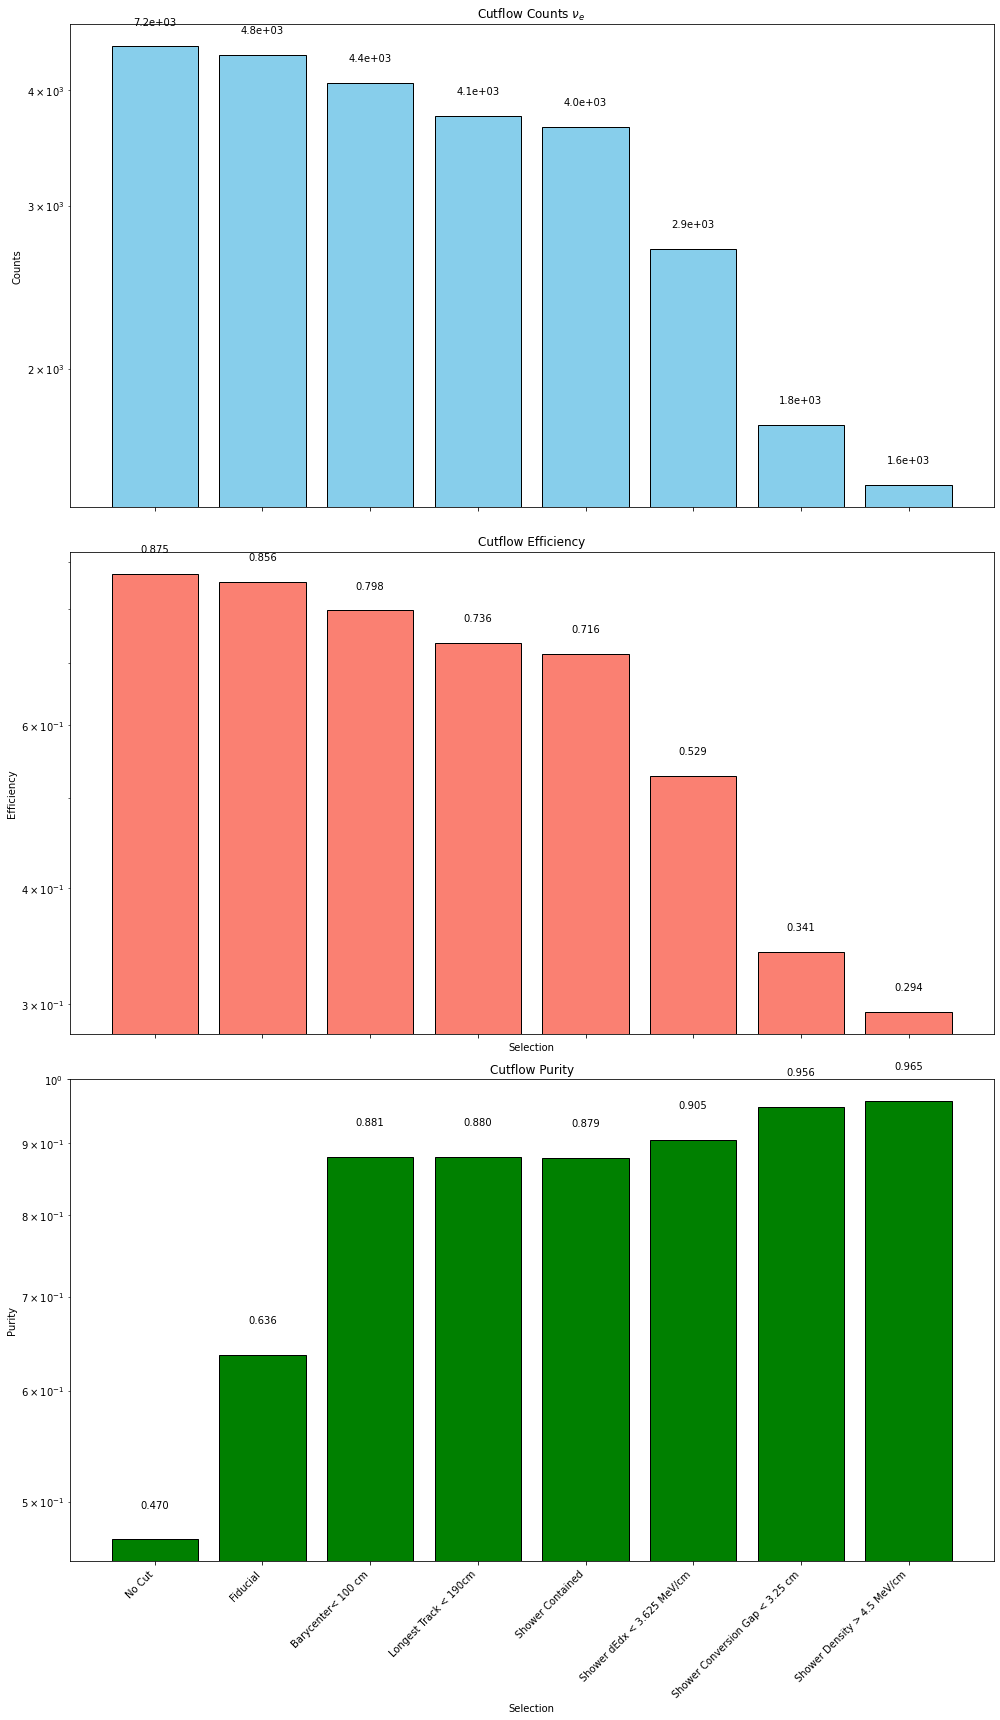

In [431]:
bin_labels = [
    "No Cut", "Fiducial", "Barycenter< 100 cm", "Longest Track < 190cm",
    "Shower Contained", #"Shower Energy > 500 MeV",
    "Shower dEdx < 3.625 MeV/cm", "Shower Conversion Gap < 3.25 cm",
    "Shower Density > 4.5 MeV/cm"
]

effVar = 'rFiducial'
totalNue = s_trueE['seqNoCut_NumNuE'].integral
eff = [x.integral/totalNue for x in s_nue.values() if effVar in x.name]
eff2 = [x.integral/totalNue for x in s_nueEff.values() if effVar in x.name]
purity = [x.integral/y.integral for x, y in zip(s_nueEff.values(), s_all.values()) if effVar in x.name]

for x, y in zip(s_nueEff.values(), s_all.values()):
    if effVar in x.name:
        print(x.name, x.integral, y.integral, x.integral / y.integral)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(14, 24), sharex=True)

#Counts, top plot
bars1 = ax1.bar(range(len(eff)), [x.integral for x in s_nueEff.values() if effVar in x.name], edgecolor="black", color="skyblue")
ax1.set_yscale("log")
ax1.set_ylabel("Counts")
ax1.set_title(r"Cutflow Counts $\nu_e$")
for bar, val in zip(bars1, s_nue.values()):
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2, height*1.05, f"{val.integral:.1e}", ha='center', va='bottom')

# Efficiency, middle plot
#bars2 = ax2.bar(range(len(eff)), eff, edgecolor="black", color="salmon", alpha=0.3, label="Original Efficiency")
barsExt = ax2.bar(range(len(eff2)), eff2, edgecolor="black", color="salmon", alpha=1, label="Max Energy Slice Efficiency")
ax2.set_yscale("log")
ax2.set_xlabel("Selection")
ax2.set_ylabel("Efficiency")
ax2.set_title("Cutflow Efficiency")
#ax2.legend()
# for bar, val in zip(bars2, eff):
#     height = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2, height*1.05, f"{val:.3f}", ha='center', va='bottom')
for bar, val in zip(barsExt, eff2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height*1.05, f"{val:.3f}", ha='center', va='bottom')

# Purity, bottom plot
bars3 = ax3.bar(range(len(purity)), purity, edgecolor="black", color="green")
ax3.set_yscale("log")
ax3.set_xlabel("Selection")
ax3.set_ylabel("Purity")
ax3.set_title("Cutflow Purity")
for bar, val in zip(bars3, purity):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height*1.05, f"{val:.3f}", ha='center', va='bottom')

# Set x-axis labels
ax3.set_xticks(range(len(bin_labels)))
ax3.set_xticklabels(bin_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()

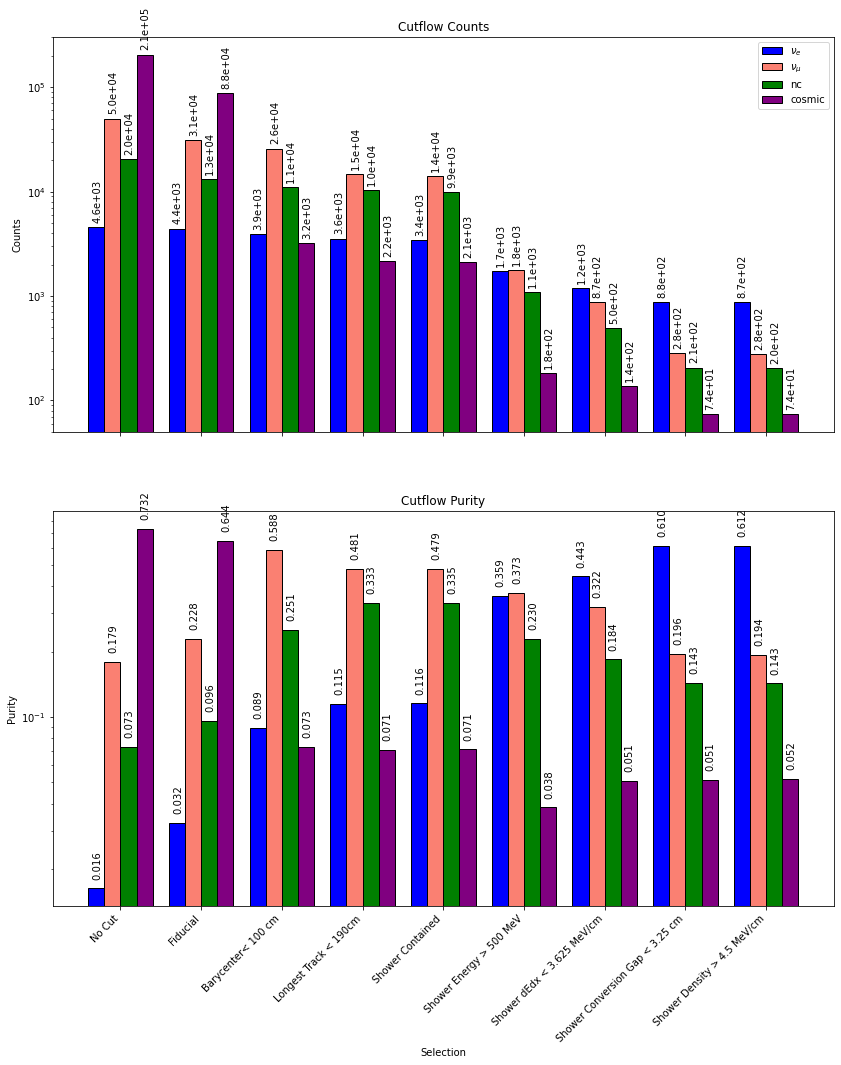

In [21]:
eff_nue = [x.integral/totalNue for x in s_nueEff.values()]
eff_numu = [x.integral/totalNue for x in s_numu.values()]
eff_nc = [x.integral/totalNue for x in s_nc.values()]
eff_cosmic = [x.integral/totalNue for x in s_cosmic.values()]

purity_nue = [x.integral/y.integral for x, y in zip(s_nueEff.values(), s_all.values()) if effVar in x.name]
purity_numu = [x.integral/y.integral for x, y in zip(s_numu.values(), s_all.values()) if effVar in x.name]
purity_nc = [x.integral/y.integral for x, y in zip(s_nc.values(), s_all.values()) if effVar in x.name]
purity_cosmic = [x.integral/y.integral for x, y in zip(s_cosmic.values(), s_all.values()) if effVar in x.name]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 16), sharex=True)

x = np.arange(len(bin_labels))   # positions for groups
width = 0.2                      # bar width

bars11 = ax1.bar(x - width*1.5, [x.integral for x in s_nueEff.values() if effVar in x.name], width, label=r"$\nu_e$", color="blue", edgecolor="black")
bars12 = ax1.bar(x - width*0.5, [x.integral for x in s_numu.values() if effVar in x.name],  width, label=r"$\nu_\mu$", color="salmon", edgecolor="black")
bars13 = ax1.bar(x + width*0.5, [x.integral for x in s_nc.values() if effVar in x.name],  width, label="nc", color="green", edgecolor="black")
bars14 = ax1.bar(x + width*1.5, [x.integral for x in s_cosmic.values() if effVar in x.name],  width, label="cosmic", color="purple", edgecolor="black")

ax1.set_yscale("log")
ax1.set_ylabel("Counts")
ax1.set_title("Cutflow Counts")
ax1.legend()

# Add bin labels
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45, ha="right")

# Print values on top of bars
for bars in [bars11, bars12, bars13, bars14]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/4, height*1.1,
                 f"{height:.1e}", ha='left', va='bottom', rotation=90)

# Bottom plot
bars21 = ax2.bar(x - width*1.5, purity_nue, width, label=r"$\nu_e$", color="blue", edgecolor="black")
bars22 = ax2.bar(x - width*0.5, purity_numu, width, label=r"$\nu_\mu$", color="salmon", edgecolor="black")
bars23 = ax2.bar(x + width*0.5, purity_nc, width, label=r"nc", color="green", edgecolor="black")
bars24 = ax2.bar(x + width*1.5, purity_cosmic, width, label=r"cosmic", color="purple", edgecolor="black")
ax2.set_yscale("log")
ax2.set_xlabel("Selection")
ax2.set_ylabel("Purity")
ax2.set_title("Cutflow Purity")
for bars in [bars21, bars22, bars23, bars24]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/4, height*1.1,
                 f"{height:.3f}", ha='left', va='bottom', rotation=90)
# # Set x-axis labels
ax2.set_xticks(range(len(bin_labels)))
ax2.set_xticklabels(bin_labels, rotation=45, ha="right")

plt.show()

In [432]:
v_seqPlots = {
    r"#nu_{e}": s_nueEff.get_dict(), 
    r"#nu_{#mu}": s_numu.get_dict(), 
    r"nc": s_nc.get_dict(), 
    r"cosmic": s_cosmic.get_dict()
}
    
v_nm1Plots = {
    r"#nu_{e}": n_nueEff.get_dict(),
    r"#nu_{#mu}": n_numu.get_dict(),
    r"nc": n_nc.get_dict(),
    r"cosmic": n_cosmic.get_dict()
}

v_seqIntPlots = {
    r"#nu_{e} CCQE": s_QE.get_dict(),
    r"#nu_{e} CCRes": s_RES.get_dict(),
    r"#nu_{e} CCDis": s_DIS.get_dict(),
    r"#nu_{e} CCCoh": s_COH.get_dict(),
    r"#nu_{e} CCMec": s_MEC.get_dict(),
    r"#nu_{e} NC": s_NC.get_dict(),
    r"#nu_{e} CCOther": s_OTHER.get_dict()
}

v_nm1IntPlots = {
    r"#nu_{e} CCQE": n_QE.get_dict(),
    r"#nu_{e} CCRes": n_RES.get_dict(),
    r"#nu_{e} CCDis": n_DIS.get_dict(),
    r"#nu_{e} CCCoh": n_COH.get_dict(),
    r"#nu_{e} CCMec": n_MEC.get_dict(),
    r"#nu_{e} NC": n_NC.get_dict(),
    r"#nu_{e} CCOther": n_OTHER.get_dict()
}

v_seqPclPlots = {
    r"e": s_ele.get_dict(),
    r"\mu": s_mu.get_dict(),
    r"p": s_pro.get_dict(),
    r"\pi^{0}": s_pi0.get_dict(),
    r"\pi^{\pm}": s_piC.get_dict(),
    r"\gamma": s_ph.get_dict(),
    r"other": s_other.get_dict()
}

v_nm1PclPlots = {
    r"e": n_ele.get_dict(),
    r"\mu": n_mu.get_dict(),
    r"p": n_pro.get_dict(),
    r"\pi^{0}": n_pi0.get_dict(),
    r"\pi^{\pm}": n_piC.get_dict(),
    r"\gamma": n_ph.get_dict(),
    r"other": n_other.get_dict()
}

labels = {"NoCut": "No Cut", "Fiducial": "Fiducial", "Barycenter": "Barycenter", "LongestTrack": "Longest Track < 190cm",
    "ShwContained": "Shower Contained", #"ShowerEnergy": "Shower Energy > 500 MeV",
    "ShowerDedx": "Shower dEdx < 3.625 MeV/cm", "ShowerConversionGap": "Shower Conversion Gap < 3.25 cm",
    "ShowerDensity": "Shower Density > 4.5 MeV/cm"}

fout = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/combinedPlotsNuGraph_nugraphScore.root", "RECREATE")

n = len(labels.keys())

h_truthNue = fin.Get("fid/seqPlots/seqNoCut_NumNuE")
totalEvents = h_truthNue.GetBinContent(7)

df_seq = pd.DataFrame({
    "selection": pd.Series(index=range(n), dtype="string"),
    r"#nu_{e}": pd.Series(index=range(n), dtype="float64"),
    r"#nu_{#mu}": pd.Series(index=range(n), dtype="float64"),
    "nc": pd.Series(index=range(n), dtype="float64"),
    "cosmic": pd.Series(index=range(n), dtype="float64"),
})

df_nm1 = pd.DataFrame({
    "selection": pd.Series(index=range(n), dtype="string"),
    r"#nu_{e}": pd.Series(index=range(n), dtype="float64"),
    r"#nu_{#mu}": pd.Series(index=range(n), dtype="float64"),
    "nc": pd.Series(index=range(n), dtype="float64"),
    "cosmic": pd.Series(index=range(n), dtype="float64"),
})

colors = [r.kBlue, r.kRed, r.kGreen+2, r.kMagenta]

makeCombinedPlots(v_seqPlots, fout, "seqPlots", totalEvents, labels, pType='seq', df=df_seq, text="Sequential", colors=colors)
makeCombinedPlots(v_nm1Plots, fout, "nm1Plots", totalEvents, labels, pType='nm1', df=df_nm1, text="N-1", colors=colors)
print("making stacked background plots")
#makeCombinedPlots(v_seqPlots, fout, "seqStacked", totalEvents, labels, pType='seq', stacked=True, data=s_data.get_dict(), text="Sequential", colors=[r.kBlue+2, r.kAzure+7, r.kGreen-2, r.kYellow-4])
#makeCombinedPlots(v_nm1Plots, fout, "nm1Stacked", totalEvents, labels, pType='nm1', stacked=True, data=n_data.get_dict(), text="N-1", colors=[r.kBlue+2, r.kAzure+7, r.kGreen-2, r.kYellow-4])
makeCombinedPlots(v_seqPlots, fout, "seqStacked", totalEvents, labels, pType='seq', stacked=True, data=None, text="Sequential", colors=[r.kBlue+2, r.kAzure+7, r.kGreen-2, r.kYellow-4])
makeCombinedPlots(v_nm1Plots, fout, "nm1Stacked", totalEvents, labels, pType='nm1', stacked=True, data=None, text="N-1", colors=[r.kBlue+2, r.kAzure+7, r.kGreen-2, r.kYellow-4])
print("making stacked interaction plots")
makeCombinedPlots(v_seqIntPlots, fout, "seqStackedInt", totalEvents, labels, pType='seq', stacked=True, text="Sequential", colors=[r.kAzure-2, r.kOrange-3, r.kRed, r.kMagenta-4, r.kGray+1, r.kViolet-6, r.kGreen-2])
makeCombinedPlots(v_nm1IntPlots, fout, "nm1StackedInt", totalEvents, labels, pType='nm1', stacked=True, text="N-1", colors=[r.kAzure-2, r.kOrange-3, r.kRed, r.kMagenta-4, r.kGray+1, r.kViolet-6, r.kGreen-2])
print("making stacked particle plots")
makeCombinedPlots(v_seqPclPlots, fout, "seqStackedPcl", totalEvents, labels, pType='seq', stacked=True, text="Sequential", colors=[r.kBlue-7, r.kAzure+1, r.kGreen-3, r.kOrange-3, r.kRed+1, r.kGray+2, r.kMagenta+2])
makeCombinedPlots(v_nm1PclPlots, fout, "nm1StackedPcl", totalEvents, labels, pType='nm1', stacked=True, text="N-1", colors=[r.kBlue-7, r.kAzure+1, r.kGreen-3, r.kOrange-3, r.kRed+1, r.kGray+2, r.kMagenta+2])

fout.Close()

making stacked background plots
making stacked interaction plots
making stacked particle plots


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [417]:
df_seq.columns = ["Selection", "nue", "numu", "nc", "cosmic"]
df_nm1.columns = ["Selection", "nue", "numu", "nc", "cosmic"]

In [418]:
df_seq['Background'] = df_seq["numu"] + df_seq["nc"] + df_seq["cosmic"]
df_seq["Total"] = df_seq["Background"] + df_seq["nue"]
df_seq['Purity'] = df_seq['nue'] / df_seq['Total']
df_seq["Delta Purity"] = df_seq["Purity"] - df_seq["Purity"].shift(1)
df_seq['Efficiency'] = df_seq['nue'] / totalEvents
df_seq["Delta Efficiency"] = df_seq["Efficiency"] - df_seq["Efficiency"].shift(1)
df_seq["S/sqrt(B)"] = df_seq["nue"] / np.sqrt(df_seq['Background'])
df_seq.round(3)

,Selection,nue,numu,nc,cosmic,Background,Total,Purity,Delta Purity,Efficiency,Delta Efficiency,S/sqrt(B)
0,No Cut,5933.426,0.0,1033.441,3256.440,4289.881,10223.307,0.580,NaN,0.875,NaN,90.591
1,Fiducial,5762.942,0.0,688.641,1800.620,2489.261,8252.203,0.698,0.118,0.850,-0.025,115.507
2,Barycenter,5353.013,0.0,618.724,101.524,720.248,6073.261,0.881,0.183,0.790,-0.060,199.461
3,Longest Track < 190cm,4922.014,0.0,593.821,89.073,682.895,5604.909,0.878,-0.003,0.726,-0.064,188.350
4,Shower Contained,4737.163,0.0,581.370,84.284,665.655,5402.818,0.877,-0.001,0.699,-0.027,183.609
5,Shower dEdx < 3.625 MeV/cm,3578.253,0.0,319.897,68.002,387.900,3966.153,0.902,0.025,0.528,-0.171,181.682
6,Shower Conversion Gap < 3.25 cm,2586.955,0.0,143.666,39.269,182.935,2769.890,0.934,0.032,0.382,-0.146,191.267
7,Shower Density > 4.5 MeV/cm,1978.766,0.0,67.044,17.240,84.284,2063.051,0.959,0.025,0.292,-0.090,215.537


In [419]:
df_nm1['Background'] = df_nm1["numu"] + df_nm1["nc"] + df_nm1["cosmic"]
df_nm1["Total"] = df_nm1["Background"] + df_nm1["nue"]
df_nm1['Purity'] = df_nm1['nue'] / df_nm1['Total']
df_nm1['Delta Purity'] = df_nm1['Purity'] - df_nm1['Purity'].loc[0]
df_nm1['Efficiency'] = df_nm1['nue'] / totalEvents
df_nm1["Delta Eff"] = df_nm1['Efficiency'] - df_nm1['Efficiency'].loc[0]
df_nm1["S/sqrt(B)"] = df_nm1["nue"] / np.sqrt(df_nm1['Background'])
df_nm1.round(3)

,Selection,nue,numu,nc,cosmic,Background,Total,Purity,Delta Purity,Efficiency,Delta Eff,S/sqrt(B)
0,No Cut,1978.766,0.0,67.044,17.240,84.284,2063.051,0.959,0.000,0.292,0.000,215.537
1,Fiducial,1996.964,0.0,90.031,20.113,110.144,2107.108,0.948,-0.011,0.295,0.003,190.278
2,Barycenter,2113.813,0.0,74.707,338.095,412.802,2526.615,0.837,-0.123,0.312,0.020,104.039
3,Longest Track < 190cm,2140.631,0.0,71.833,19.156,90.989,2231.619,0.959,0.000,0.316,0.024,224.413
4,Shower Contained,2056.346,0.0,67.044,18.198,85.242,2141.588,0.960,0.001,0.303,0.011,222.725
5,Shower dEdx < 3.625 MeV/cm,2641.548,0.0,138.878,22.029,160.906,2802.454,0.943,-0.017,0.390,0.098,208.244
6,Shower Conversion Gap < 3.25 cm,2719.128,0.0,147.498,31.607,179.104,2898.232,0.938,-0.021,0.401,0.109,203.178
7,Shower Density > 4.5 MeV/cm,2586.955,0.0,143.666,39.269,182.935,2769.890,0.934,-0.025,0.382,0.090,191.267


Max Ratio 40.18272399902344 at selection 0.4000000059604645


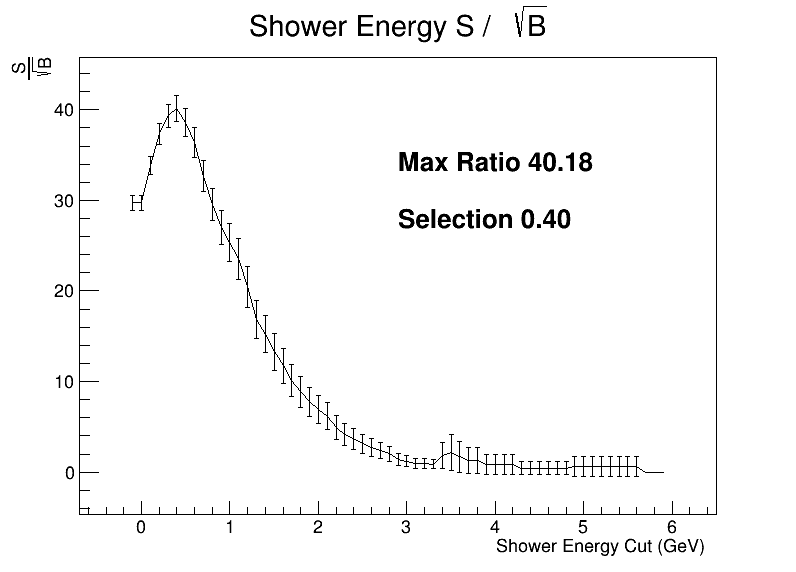

In [269]:
%jsroot off
c1 = r.TCanvas("c1", "c1", 800, 600)
h_ele = fin.Get("nue/nm1Plots/nm1ShowerEnergy_rShowerEnergy")
h_mu = fin.Get("numu/nm1Plots/nm1ShowerEnergy_rShowerEnergy")
h_nc = fin.Get("nc/nm1Plots/nm1ShowerEnergy_rShowerEnergy")
h_cosmic = fin.Get("cosmic/nm1Plots/nm1ShowerEnergy_rShowerEnergy")

h_background = h_mu.Clone()
h_background.Add(h_nc)
h_background.Add(h_cosmic)

s = []
b = []
bins = []
for ibin in range(h_ele.GetNbinsX()+1):
    s.append(h_ele.Integral(ibin, h_ele.GetNbinsX()+1))
    b.append(h_background.Integral(ibin, h_background.GetNbinsX()+1))
    bins.append(h_ele.GetXaxis().GetBinLowEdge(ibin))


s = np.array(s)
b = np.array(b)
errY = [np.sqrt(xs / xb * (1 + 0.25 * xs / xb)) for xs, xb in zip(s, b)]
errX = np.zeros(len(s))

b = np.sqrt(b)
ratio = s/b

s = arr('f', s)
b = arr('f', b)
errY = arr('f', errY)
errX = arr('f', errX)
ratio = arr('f', ratio)
bins = arr('f', bins)

h_ratioEnergy = r.TGraphErrors(len(bins), bins, ratio, errX, errY)

c1.Clear()
h_ratioEnergy.Draw()
h_ratioEnergy.SetTitle("Shower Energy S / #sqrt{B};Shower Energy Cut (GeV);#frac{S}{#sqrt{B}}")
c1.Draw()

t1 = r.TLatex()
t1.DrawLatexNDC(0.5, 0.7, f"Max Ratio {np.max(ratio):.2f}")
t2 = r.TLatex()
t2.DrawLatexNDC(0.5, 0.6, f"Selection {bins[np.argmax(ratio)]:.2f}")
print(f"Max Ratio {np.max(ratio)} at selection {bins[np.argmax(ratio)]}")

Max Ratio 38.5931282043457 at selection 180.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


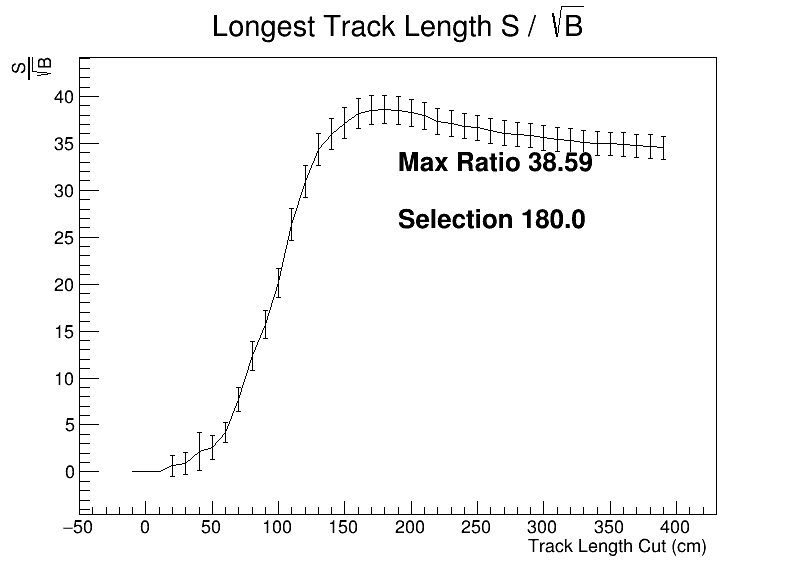

In [270]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_ele = fin.Get("nue/nm1Plots/nm1LongestTrack_rLongestTrackLength")
h_mu = fin.Get("numu/nm1Plots/nm1LongestTrack_rLongestTrackLength")
h_nc = fin.Get("nc/nm1Plots/nm1LongestTrack_rLongestTrackLength")
h_cosmic = fin.Get("cosmic/nm1Plots/nm1LongestTrack_rLongestTrackLength")

h_background = h_mu.Clone()
h_background.Add(h_nc)
h_background.Add(h_cosmic)

s = []
b = []
bins = []
for ibin in range(h_ele.GetNbinsX()+1):
    s.append(h_ele.Integral(0, ibin))
    b.append(h_background.Integral(0, ibin))
    bins.append(h_ele.GetXaxis().GetBinLowEdge(ibin))

s = np.array(s)
b = np.array(b)
errY = [
    np.sqrt(xs / xb * (1 + 0.25 * xs / xb)) if xb > 0 else np.sqrt(xs * (1 + 0.25 * xs))
    for xs, xb in zip(s, b)
]
errX = np.zeros(len(s))

b = np.sqrt(b)
ratio = [xs/xb if xb > 0 else 0 for xs, xb in zip(s, b)]

s = arr('f', s)
b = arr('f', b)
errY = arr('f', errY)
errX = arr('f', errX)
ratio = arr('f', ratio)
bins = arr('f', bins)

h_ratioEnergy = r.TGraphErrors(len(bins), bins, ratio, errX, errY)

c1.Clear()
h_ratioEnergy.Draw()
h_ratioEnergy.SetTitle("Longest Track Length S /#sqrt{B};Track Length Cut (cm);#frac{S}{#sqrt{B}}")
c1.Draw()

t1 = r.TLatex()
t1.DrawLatexNDC(0.5, 0.7, f"Max Ratio {np.max(ratio):.2f}")
t2 = r.TLatex()
t2.DrawLatexNDC(0.5, 0.6, f"Selection {bins[np.argmax(ratio)]}")

print(f"Max Ratio {np.max(ratio)} at selection {bins[np.argmax(ratio)]}")

### Make Efficiency Plots

Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 11 points have been skipped


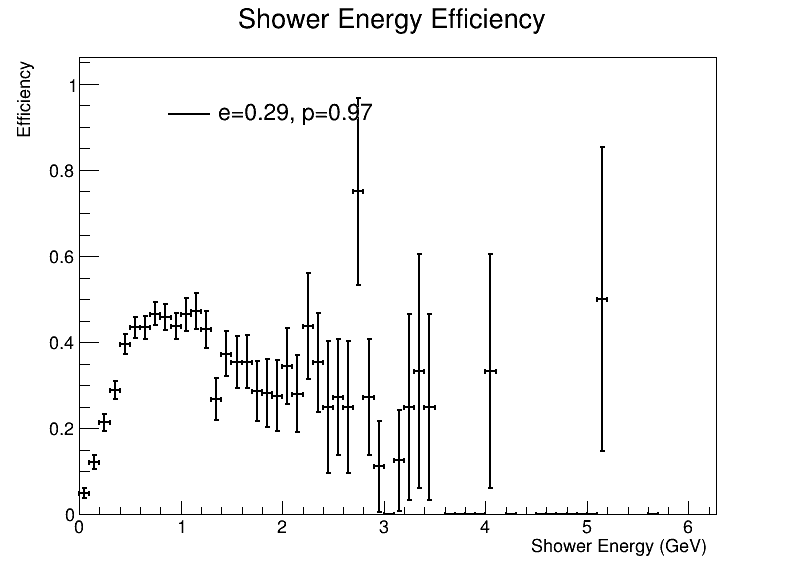

In [433]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = s_nueEff['seqShowerDensity_rShowerEnergy'].hist.Clone()
h_den = s_nueEff['seqNoCut_rShowerEnergy'].hist.Clone()
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower Energy Efficiency;Shower Energy (GeV);Efficiency")
g_eff.SetLineColor(r.kBlack)
g_eff.Draw("AP")

totalNue = s_trueE['seqNoCut_NumNuE'].integral
eff = s_nueEff['seqShowerDensity_rFiducial'].integral / totalNue

purity = s_nueEff['seqShowerDensity_rFiducial'].integral / s_all['seqShowerDensity_rFiducial'].integral

l1 = r.TLegend(0.2, 0.7, 0.5, 0.9)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(g_eff, f"e={eff:.2f}, p={purity:.2f}", "lp")
l1.Draw()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 4 points have been skipped


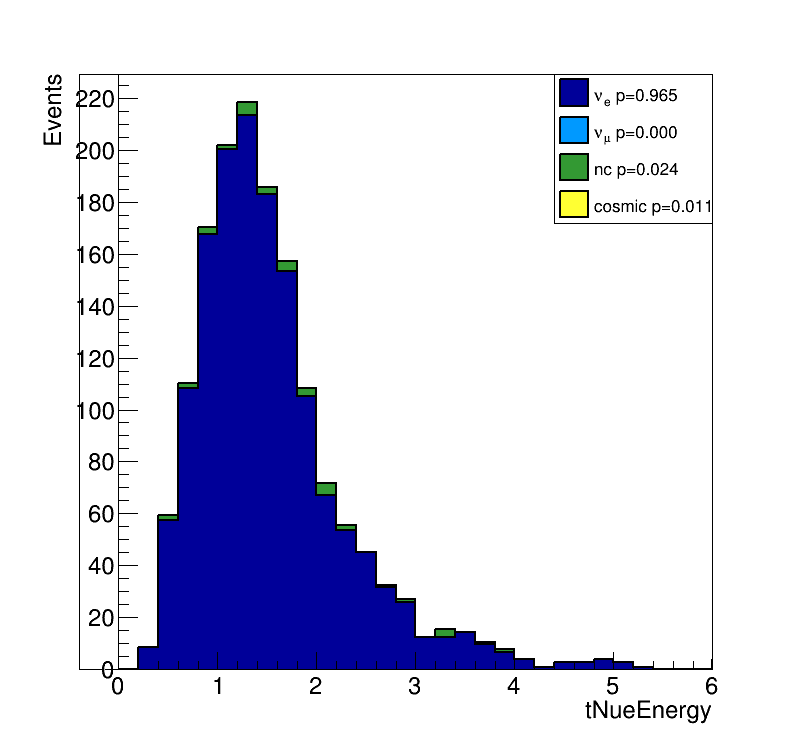

In [435]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = s_nueEff['seqShowerDensity_kShowerCosAngle'].hist.Clone()
h_den = s_nueEff['seqNoCut_kShowerCosAngle'].hist.Clone()
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower cos(#theta) Efficiency;Shower cos(#theta);Efficiency")
g_eff.SetLineColor(r.kBlack)
g_eff.Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms


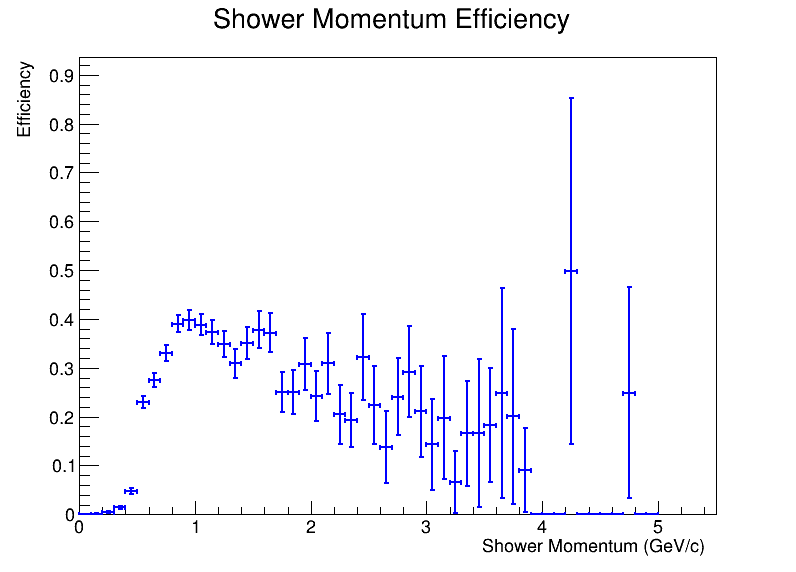

In [18]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = s_nueEff['seqShowerDensity_kShowerP'].hist.Clone()
h_num.Rebin(2)
h_den = s_nueEff['seqNoCut_kShowerP'].hist.Clone()
h_den.Rebin(2)
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower Momentum Efficiency;Shower Momentum (GeV/c);Efficiency")
g_eff.Draw("AP")
c1.Draw()



### Make stacked plots pretty

In [436]:
fPlots = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/combinedPlotsNuGraph_nugraphScore.root", "READ")
fPlots.cd("seqStacked")
fPlots.ls()

TFile**		/nashome/m/micarrig/icarus/NuE/combinedPlotsNuGraph_nugraphScore.root	
 TFile*		/nashome/m/micarrig/icarus/NuE/combinedPlotsNuGraph_nugraphScore.root	
  TDirectoryFile*		seqStacked	seqStacked
   KEY: TCanvas	seqShowerDensity_tNueEnergy;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerEnergy;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerDeDx;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerDensity;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerConversionGap;1	c1
   KEY: TCanvas	seqShowerDensity_rLongestTrackLength;1	c1
   KEY: TCanvas	seqShowerDensity_rBarycenterDeltaZ;1	c1
   KEY: TCanvas	seqShowerDensity_rBarycenterRadius;1	c1
   KEY: TCanvas	seqShowerDensity_rFiducial;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerContained;1	c1
   KEY: TCanvas	seqShowerDensity_rMuonChi2;1	c1
   KEY: TCanvas	seqShowerDensity_tInteractionMode;1	c1
   KEY: TCanvas	seqShowerDensity_tNeutrinoType;1	c1
   KEY: TCanvas	seqShowerDensity_rSubleadingShowerEnergy;1	c1
   KEY: TCanvas	seqShowerDensity_rShowerEResid

In [437]:
%jsroot off
c = fPlots.Get("seqStacked/seqShowerDensity_tNueEnergy")
c.SetLeftMargin(0.15)

rebinFactor = 2
# Loop over the objects in the canvas and rebin TH1s
objects = c.GetListOfPrimitives()
for obj in objects:
    if obj.InheritsFrom("TH1"):
        obj.Rebin(rebinFactor)
        obj.SetMaximum(8000)
    elif obj.InheritsFrom("THStack"):
        # For THStack, we need to rebin the histograms in the stack
        stack_hists = obj.GetHists()
        for hist in stack_hists:
            hist.Rebin(rebinFactor)
            hist.SetMaximum(8000)
c.Update()
c.Draw()
#c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/trueNueEnergy.png")

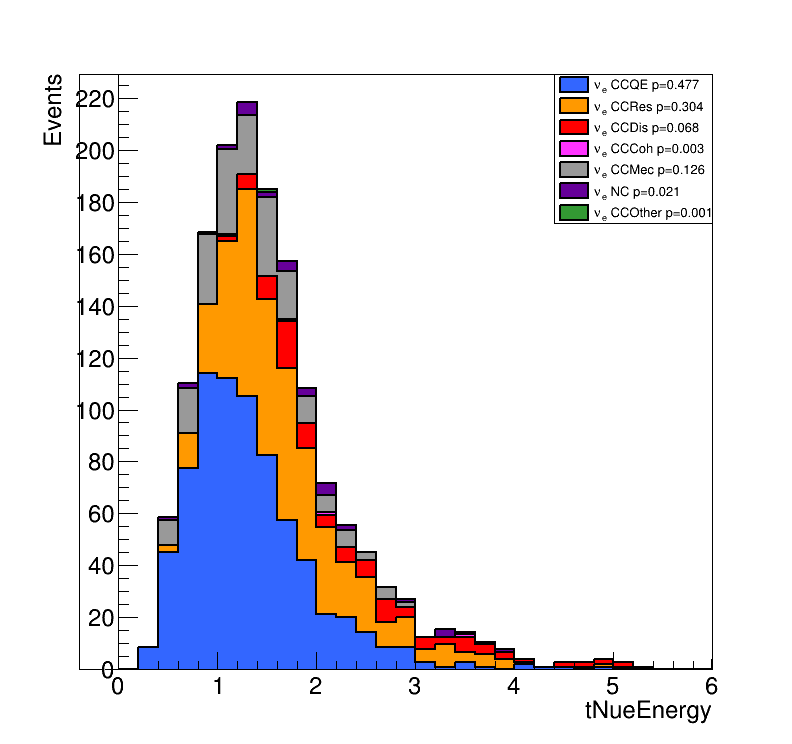

In [438]:
c.Draw()

In [439]:
c = fPlots.Get("seqStackedInt/seqShowerDensity_tNueEnergy")
c.SetLeftMargin(0.15)

rebinFactor = 2
# Loop over the objects in the canvas and rebin TH1s
objects = c.GetListOfPrimitives()
for obj in objects:
    if obj.InheritsFrom("TH1"):
        obj.Rebin(rebinFactor)
        obj.SetMaximum(8000)
    elif obj.InheritsFrom("THStack"):
        # For THStack, we need to rebin the histograms in the stack
        stack_hists = obj.GetHists()
        for hist in stack_hists:
            hist.Rebin(rebinFactor)
            hist.SetMaximum(8000)
c.Update()
c.Draw()
#c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/trueNueEnergyInt.png")

TFrame
h_stack
TPave


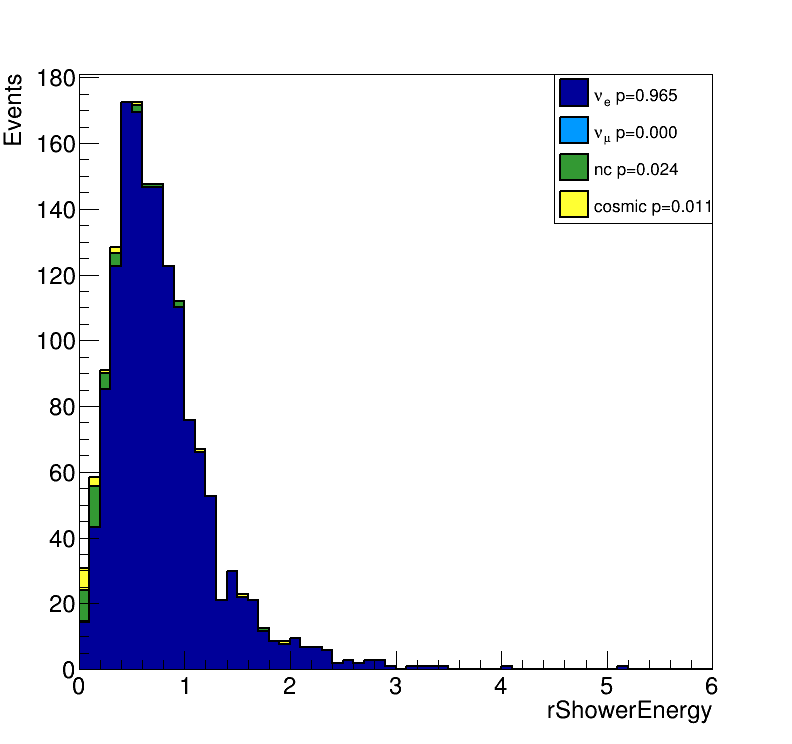

In [440]:
%jsroot off
c = fPlots.Get('seqStacked/seqShowerDensity_rShowerEnergy')

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())


# upper = c.GetPrimitive("pad1")
# upper.cd()
# hstack = upper.GetPrimitive("h_stack")
# #hstack.Draw("same a")
# maxY = hstack.GetStack().Last().GetMaximum()
# hstack.SetMaximum(maxY*1.7)
# hstack.SetMinimum(0)
# hstack.GetXaxis().SetRangeUser(0, 3.0)  # Set x-axis range from 0 to 3 GeV
# upper.Modified()
# upper.Update()
# l = r.TLine(0.5, 0, 0.5, maxY)
# #l.SetNDC(True)
# l.SetLineColor(r.kRed)
# l.SetLineWidth(2)
# l.SetLineStyle(2)
# l.Draw("same")

# lower = c.GetPrimitive("pad2")
# lower.cd()
# h_ratio = lower.GetPrimitive("h_ratio")
# maxX = h_ratio.GetXaxis().GetXmax()
# l2 = r.TLine(0, 1, maxX, 1)
# l2.SetLineStyle(2)
# l2.Draw("same")

c.Draw()
# c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergy.png")

In [384]:
c.Draw()

ReferenceError: attempt to access a null-pointer

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyInt.png has been created


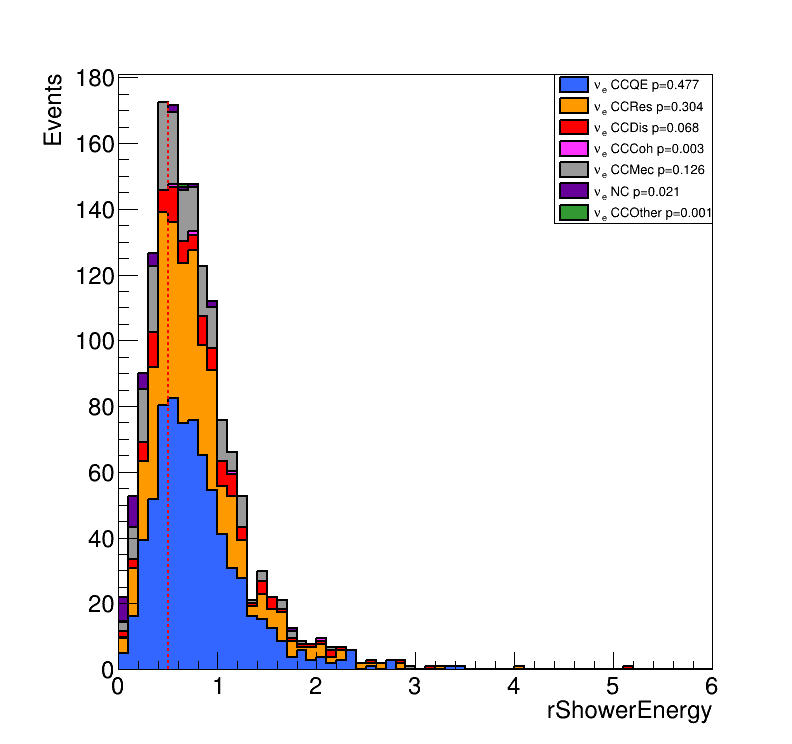

In [441]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rShowerEnergy')
c.SetLeftMargin(0.15)

hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0.5, 0, 0.5, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyInt.png")

In [100]:
c = fPlots.Get('nm1Stacked/nm1ShowerDedx_rShowerDeDx')

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())


upper = c.GetPrimitive("pad1")
upper.cd()
hstack = upper.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.SetMaximum(maxY*1.3)
hstack.SetMinimum(0)
upper.Modified()
upper.Update()
l = r.TLine(3.625, 0, 3.625, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

lower = c.GetPrimitive("pad2")
lower.cd()
h_ratio = lower.GetPrimitive("h_ratio")
maxX = h_ratio.GetXaxis().GetXmax()
l2 = r.TLine(0, 1, maxX, 1)
l2.SetLineStyle(2)
l2.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerDeDx.png")

pad1
pad2


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerDeDx.png has been created


In [101]:
c.Draw()

In [102]:
c = fPlots.Get('nm1StackedInt/nm1ShowerDedx_rShowerDeDx')
c.SetLeftMargin(0.15)

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())

hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(3.625, 0, 3.625, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerDeDxInt.png")

TFrame
h_stack

TPave


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerDeDxInt.png has been created


In [103]:
c = fPlots.Get('seqStacked/seqShowerDensity_rShowerEResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEResidual.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEResidual.png has been created


In [104]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rShowerEResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEResidualInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEResidualInt.png has been created


In [107]:
c = fPlots.Get('nm1Stacked/nm1LongestTrack_rLongestTrackLength')

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())


upper = c.GetPrimitive("pad1")
upper.cd()
hstack = upper.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.SetMaximum(maxY*1.7)
hstack.SetMinimum(0)
upper.Modified()
upper.Update()
l = r.TLine(190, 0, 190, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

lower = c.GetPrimitive("pad2")
lower.cd()
h_ratio = lower.GetPrimitive("h_ratio")
maxX = h_ratio.GetXaxis().GetXmax()
l2 = r.TLine(0, 1, maxX, 1)
l2.SetLineStyle(2)
l2.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoLongestTrack.png")

pad1
pad2


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoLongestTrack.png has been created


In [108]:
c = fPlots.Get('nm1StackedInt/nm1LongestTrack_rLongestTrackLength')
c.SetLeftMargin(0.15)

hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(190, 0, 190, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoLongestTrackInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoLongestTrackInt.png has been created


In [39]:
c = fPlots.Get('seqStacked/seqShowerDensity_rShowerLenResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")
c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerLenResidual.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerLenResidual.png has been created


In [40]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rShowerLenResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerLenResidualInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerLenResidualInt.png has been created


In [41]:
c = fPlots.Get('seqStacked/seqShowerDensity_rVertexResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoVertexResidual.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoVertexResidual.png has been created


In [42]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rVertexResidual')
c.SetLeftMargin(0.15)
hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
l = r.TLine(0, 0, 0, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoVertexResidualInt.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoVertexResidualInt.png has been created


In [111]:
c = fPlots.Get('seqStacked/seqShowerDensity_rShowerEnergy')

objects = c.GetListOfPrimitives()
for obj in objects:
    print(obj.GetName())


upper = c.GetPrimitive("pad1")
upper.cd()
hstack = upper.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.SetMaximum(maxY*1.4)
hstack.SetMinimum(0)
hstack.GetXaxis().SetRangeUser(0, 3)
upper.Modified()
upper.Update()
l = r.TLine(0.5, 0, 0.5, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

lower = c.GetPrimitive("pad2")
lower.cd()
h_ratio = lower.GetPrimitive("h_ratio")
maxX = h_ratio.GetXaxis().GetXmax()
l2 = r.TLine(0, 1, maxX, 1)
l2.SetLineStyle(2)
l2.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyFull.png")

pad1
pad2


Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyFull.png has been created


In [112]:
c = fPlots.Get('seqStackedInt/seqShowerDensity_rShowerEnergy')
c.SetLeftMargin(0.15)

hstack = c.GetPrimitive("h_stack")
maxY = hstack.GetStack().Last().GetMaximum()
hstack.GetXaxis().SetRangeUser(0, 3)
c.Modified()
c.Update()
l = r.TLine(0.5, 0, 0.5, maxY)
#l.SetNDC(True)
l.SetLineColor(r.kRed)
l.SetLineWidth(2)
l.SetLineStyle(2)
l.Draw("same")

c.Draw()
c.SaveAs("/nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyIntFull.png")

Info in <TCanvas::Print>: png file /nashome/m/micarrig/icarus/NuE/nueOutputs/plots/recoShowerEnergyIntFull.png has been created


In [110]:
c.Draw()

### Check east vs west cryo

In [45]:
f_E = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcV3West/mc.root", "READ") #note had these backwards in cut, cut not fixed
f_W = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcV3East/mc.root", "READ")

s_e_all = getHistList(f_E, "allEvents/seqPlots")
s_e_nueEff = getHistList(f_E, "nueEff/seqPlots", skip='MaxShowerEnergySlice')
n_e_all = getHistList(f_E, "allEvents/nm1Plots")
n_e_nueEff = getHistList(f_E, "nueEff/nm1Plots", skip='MaxShowerEnergySlice')

s_w_all = getHistList(f_W, "allEvents/seqPlots")
s_w_nueEff = getHistList(f_W, "nueEff/seqPlots", skip='MaxShowerEnergySlice')
n_w_all = getHistList(f_W, "allEvents/nm1Plots")
n_w_nueEff = getHistList(f_W, "nueEff/nm1Plots", skip='MaxShowerEnergySlice')

In [541]:
s_EW = {
    'East': s_e_all.get_dict(),
    'West': s_w_all.get_dict(),
}

s_nue_EW = {
    'East': s_e_nueEff.get_dict(),
    'West': s_w_nueEff.get_dict(),
}

n_EW = {
    'East': n_e_all.get_dict(),
    'West': n_w_all.get_dict(),
}

n_nue_EW = {
    'East': n_e_nueEff.get_dict(),
    'West': n_w_nueEff.get_dict(),
}

labels = {"NoCut": "No Cut", "Fiducial": "Fiducial", "Barycenter": "Barycenter", "LongestTrack": "Longest Track < 190cm",
    "ShwContained": "Shower Contained", "ShowerEnergy": "Shower Energy > 500 MeV",
    "ShowerDedx": "Shower dEdx < 3.625 MeV/cm", "ShowerConversionGap": "Shower Conversion Gap < 3.25 cm",
    "ShowerDensity": "Shower Density > 4.5 MeV/cm"}

fout = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/compareEW.root", "RECREATE")

n = len(labels.keys())

h_truthNue = fin.Get("fid/seqPlots/seqNoCut_NumNuE")
totalEvents = h_truthNue.GetBinContent(7)

makeCombinedPlots(s_EW, fout, "seqPlotsAll", totalEvents, labels, pType='seq', df=df_seq, text="Sequential", data=True, colors=[r.kBlue, r.kRed])
makeCombinedPlots(s_nue_EW, fout, "seqPlotsNue", totalEvents, labels, pType='seq', df=df_seq, text="Sequential", data=True, colors=[r.kBlue, r.kRed])
makeCombinedPlots(n_EW, fout, "nm1PlotsAll", totalEvents, labels, pType='nm1', df=df_seq, text="Sequential", data=True, colors=[r.kBlue, r.kRed])
makeCombinedPlots(n_nue_EW, fout, "nm1PlotsNue", totalEvents, labels, pType='nm1', df=df_seq, text="Sequential", data=True, colors=[r.kBlue, r.kRed])

fout.Close()


## Determine binning

In [145]:
f_sel = uproot.open("root://fndcadoor.fnal.gov:/icarus/scratch/users/micarrig/nueInclusive3/outputs/merged.root:t_selEff/t_selEff")
f_all = uproot.open("root://fndcadoor.fnal.gov:/icarus/scratch/users/micarrig/nueInclusive3/outputs/merged.root:t_eff/t_eff")
f_sel.keys()


['tNueEnergy',
 'rShowerEnergy',
 'rShowerDeDx',
 'rShowerDensity',
 'rShowerConversionGap',
 'rLongestTrackLength',
 'rBarycenterDeltaZ',
 'rBarycenterRadius',
 'rFiducial',
 'rShowerContained',
 'rMuonChi2',
 'tInteractionMode',
 'tNeutrinoType',
 'rSubleadingShowerEnergy',
 'rShowerEResidual',
 'rSecondaryShowerEResidual',
 'rNeutrinoScore',
 'tShowerLength',
 'rShowerLenResidual',
 'rVertexResidual',
 'tShowerE',
 'tSubleadingShowerE',
 'kLongestTrackLengthResidual',
 'tTLongestTrackLength',
 'kShowerCosAngle',
 'kShowerP',
 'tFiducial',
 'rShowerLength',
 'rShowerEndX',
 'rShowerEndY',
 'rShowerEndZ',
 'rShowerStartX',
 'rShowerStartY',
 'rShowerStartZ',
 'rVertexCryo',
 'rTruthPDGID',
 'rClearCosmic',
 'rLargestShowerCut',
 'Run',
 'Subrun',
 'Evt',
 'Slice']

In [146]:
c1 = r.TCanvas("c1", "c1", 800, 600)
c1.Clear()

fin = r.TFile.Open("root://fndcadoor.fnal.gov:/icarus/scratch/users/micarrig/nueInclusive3/outputs/merged.root", "READ")

h = fin.Get("nueEff/seqPlots/seqNoCut_rShowerEnergy")
hCut = fin.Get("nueEff/seqPlots/seqShowerDensity_rShowerEnergy")

n_typeAll = f_all['tNeutrinoType'].array() == 2
initialCutsAll = (f_all['rLargestShowerCut'].array() > 0) & (f_all['rClearCosmic'].array() == 0) & (f_all['tFiducial'].array() > 0)
e_showerAll = f_all['rShowerEnergy'].array()[n_typeAll & initialCutsAll]

n_type = f_sel['tNeutrinoType'].array() == 2
initialCuts = (f_sel['rLargestShowerCut'].array() > 0) & (f_sel['rClearCosmic'].array() == 0) & (f_sel['tFiducial'].array() > 0)
e_shower = f_sel['rShowerEnergy'].array()[n_type & initialCuts]

h_showerE = r.TH1F("h_showerE", "Shower Energy after Selection;Reconstructed Shower Energy (GeV);Events", 60, 0, 6)
h_showerE.FillN(len(e_shower), arr('d', e_shower), np.ones(len(e_shower)))

h_showerE_all = r.TH1F("h_showerE_all", "Shower Energy before Selection;Reconstructed Shower Energy (GeV);Events", 60, 0, 6)
h_showerE_all.FillN(len(e_showerAll), arr('d', e_showerAll), np.ones(len(e_showerAll)))

#h.Scale(0.0035002192085227925)
#h.Scale(0.0033707571278005317)

h.Scale(0.0033707571278005317)
hCut.Scale(0.0033707571278005317)

h.SetLineColor(r.kRed)
h.Draw("P")
h_showerE_all.SetLineColor(r.kRed)
h_showerE_all.Draw("same hist")

hCut.SetLineColor(r.kBlue)
hCut.Draw("same P")
h_showerE.SetLineColor(r.kBlue)
h_showerE.Draw("same hist")

c1.Draw()

# for ibin in range(1, h.GetNbinsX()+1):
#     print(f"{h.GetBinContent(ibin)}, {h_showerE_all.GetBinContent(ibin)}, ratio {h_showerE_all.GetBinContent(ibin)/h.GetBinContent(ibin) if h.GetBinContent(ibin) > 0 else 0}")

print(h.GetEntries(), h_showerE.GetEntries())

12039.0 3650.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [346]:
def getEffGraph(num, den, title, sel=None, xlim=(0, 6), nbins=60, annotations=None, annPos=(0.7, 0.7)):

    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True,
        figsize=(15, 12)
    )

    if isinstance(title, str):
        print("Need to provide a title, x and y labels as a tuple/list.")
        return

    ax1.hist(num, bins=nbins, range=xlim, histtype='step', color='blue', alpha=1, label=r'True $\nu_{e}$ Selected (After Cuts)')
    ax1.hist(den, bins=nbins, range=xlim, histtype='step', color='orange', alpha=1, label=r'True $\nu_{e}$ All (Before Cuts)')
    if sel is not None:
        ax1.hist(sel, bins=nbins, range=xlim, histtype='step', color='green', alpha=1, label=r'All Selected Events (After Cuts)')
    ax1.legend()
    ax1.set_ylabel(title[2])
    ax1.set_xlabel(title[1])
    ax1.set_title(title[0])
    ax1.set_yscale('log')

    h_num = np.histogram(ak.to_numpy(num), bins=nbins, range=xlim)[0]
    h_den = np.histogram(ak.to_numpy(den), bins=nbins, range=xlim)[0]
    eff = np.divide(h_num, h_den, out=np.full_like(h_num, np.nan, dtype=float), where=h_den > 0)
    pur = None
    if sel is not None:
        h_sel = np.histogram(ak.to_numpy(sel), bins=nbins, range=xlim)[0]
        pur = np.divide(h_num, h_sel, out=np.full_like(h_num, np.nan, dtype=float), where=h_sel > 0)

    npoints = (xlim[1] - xlim[0]) / nbins
    points = np.linspace(xlim[0] + npoints/2, xlim[1] - npoints/2, nbins)
    yerr = np.where(h_den > 0, np.sqrt(eff * (1 - eff) / h_den), 0.0)
    ax2.errorbar(points, eff, yerr=yerr, fmt='o', color='black', label='Efficiency')
    if pur is not None:
        purErr = np.where(h_sel > 0, np.sqrt(pur * (1 - pur) / h_sel), 0.0)
        ax2.errorbar(points, pur, yerr=purErr, fmt='o', color='red', label='Purity')
        ax2.legend()
        ax2.set_ylabel('Efficiency/Purity')
    else:
        ax2.set_ylabel('Efficiency')
    ax2.set_ylim(0, 1.1)
    ax2.set_xlabel('Reconstructed Shower Energy (GeV)')

    # Optional annotations on the top plot (top-right corner)
    if annotations:
        text = "\n".join(str(s) for s in annotations)
        ax1.text(
            annPos[0], annPos[1], text,
            transform=ax1.transAxes,
            ha='left', va='top',
            fontsize=12,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
        )
        eff = len(num) / len(den) if len(den) > 0 else float('nan')
        pur = len(num) / len(sel) if sel is not None and len(sel) > 0 else float('nan')
        if sel is not None:
            ax1.text(
                annPos[0], annPos[1]+0.1, f"Efficiency: {eff:.3f}, Purity: {pur:.3f}",
                transform=ax1.transAxes,
                ha='left', va='top',
                fontsize=12,
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
            )
        else:
            ax1.text(
                annPos[0], annPos[1]+0.1, f"Efficiency: {eff:.3f}",
                transform=ax1.transAxes,
                ha='left', va='top',
                fontsize=12,
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
            )

def getEffGraphBins(num, den, title, sel=None, bins=np.linspace(0, 6, 60), annotations=None, annPos=(0.7, 0.7)):

    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True,
        figsize=(15, 12)
    )

    if isinstance(title, str):
        print("Need to provide a title, x and y labels as a tuple/list.")
        return

    ax1.hist(num, bins=bins, histtype='step', color='blue', alpha=1, label=r'True $\nu_{e}$ Selected (After Cuts)')
    ax1.hist(den, bins=bins, histtype='step', color='orange', alpha=1, label=r'True $\nu_{e}$ All (Before Cuts)')
    if sel is not None:
        ax1.hist(sel, bins=bins, histtype='step', color='green', alpha=1, label=r'All Selected Events (After Cuts)')
    ax1.legend()
    ax1.set_ylabel(title[2])
    ax1.set_xlabel(title[1])
    ax1.set_title(title[0])
    ax1.set_yscale('log')

    h_num = np.histogram(ak.to_numpy(num), bins=bins)[0]
    h_den = np.histogram(ak.to_numpy(den), bins=bins)[0]
    eff = np.divide(h_num, h_den, out=np.full_like(h_num, np.nan, dtype=float), where=h_den > 0)
    pur = None
    if sel is not None:
        h_sel = np.histogram(ak.to_numpy(sel), bins=bins)[0]
        pur = np.divide(h_num, h_sel, out=np.full_like(h_num, np.nan, dtype=float), where=h_sel > 0)

    npoints = len(bins) - 1
    points = [round((bins[ibin+1] + bins[ibin])/2, 2) for ibin in range(len(bins)-1)]
    yerr = np.where(h_den > 0, np.sqrt(eff * (1 - eff) / h_den), 0.0)
    xerr = [(bins[ibin+1] - bins[ibin])/2 for ibin in range(len(bins)-1)]
    ax2.errorbar(points, eff, yerr=yerr, xerr=xerr, fmt='o', color='black', label='Efficiency')
    if pur is not None:
        purErr = np.where(h_sel > 0, np.sqrt(pur * (1 - pur) / h_sel), 0.0)
        ax2.errorbar(points, pur, yerr=purErr, xerr=xerr, fmt='o', color='red', label='Purity')
        ax2.legend()
        ax2.set_ylabel('Efficiency/Purity')
    else:
        ax2.set_ylabel('Efficiency')
    ax2.set_ylim(0, 1.1)
    ax2.set_xlabel('Reconstructed Shower Energy (GeV)')

    # Optional annotations on the top plot (top-right corner)
    if annotations:
        text = "\n".join(str(s) for s in annotations)
        ax1.text(
            annPos[0], annPos[1], text,
            transform=ax1.transAxes,
            ha='left', va='top',
            fontsize=12,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
        )
        eff = len(num) / len(den) if len(den) > 0 else float('nan')
        pur = len(num) / len(sel) if sel is not None and len(sel) > 0 else float('nan')
        if sel is not None:
            ax1.text(
                annPos[0], annPos[1]+0.1, f"Efficiency: {eff:.3f}, Purity: {pur:.3f}",
                transform=ax1.transAxes,
                ha='left', va='top',
                fontsize=12,
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
            )
        else:
            ax1.text(
                annPos[0], annPos[1]+0.1, f"Efficiency: {eff:.3f}",
                transform=ax1.transAxes,
                ha='left', va='top',
                fontsize=12,
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
            )

In [313]:
initialCutsNuE = (f_all['rLargestShowerCut'].array() > 0) & (f_all['rClearCosmic'].array() == 0) & (f_all['tFiducial'].array() > 0) & (f_all['tNeutrinoType'].array() == 2)
initialCutsAll = (f_all['rLargestShowerCut'].array() > 0) & (f_all['rClearCosmic'].array() == 0) & (f_all['tFiducial'].array() > 0)
selections = {
    "fiducial": f_all['rFiducial'].array() == 1, #fiducial cut
    "barycenter_z < 100 cm": (f_all['rBarycenterDeltaZ'].array() < 100) & (f_all['rBarycenterDeltaZ'].array() >= 0), #barycenter cut
    "barycenter_radius < 100 cm": (f_all['rBarycenterRadius'].array() < 100) & (f_all['rBarycenterRadius'].array() >= 0), #barycenter cut
    "trackLength < 190 cm": (f_all['rLongestTrackLength'].array() < 190), #longest track cut
    "showerContained": (f_all['rShowerContained'].array() == 1), #shower contained cut
    #"showerEnergy > 0.5 GeV": (f_all['rShowerEnergy'].array() > 0.5), #shower energy cut
    "showerDeDx < 3.625 MeV/cm": (f_all['rShowerDeDx'].array() < 3.625), #shower dedx cut
    "showerConversionGap < 3.25 cm": (f_all['rShowerConversionGap'].array() < 3.25), #shower conversion gap cut
    "showerDensity > 4.5 MeV/cm": (f_all['rShowerDensity'].array() > 4.5) #shower density cut
}

Applying fiducial cut:
bins [0.0, 0.22, 0.3, 0.36, 0.41, 0.46, 0.5, 0.55, 0.6, 0.64, 0.69, 0.75, 0.8, 0.86, 0.92, 0.99, 1.08, 1.2, 1.37, 1.69, 6.0] [0.11, 0.039999999999999994, 0.03, 0.024999999999999994, 0.025000000000000022, 0.01999999999999999, 0.025000000000000022, 0.024999999999999967, 0.020000000000000018, 0.024999999999999967, 0.030000000000000027, 0.025000000000000022, 0.02999999999999997, 0.030000000000000027, 0.034999999999999976, 0.04500000000000004, 0.05999999999999994, 0.08500000000000008, 0.15999999999999992, 2.1550000000000002]
Applying barycenter_z < 100 cm cut:
bins [0.0, 0.22, 0.3, 0.36, 0.41, 0.46, 0.5, 0.55, 0.6, 0.64, 0.69, 0.75, 0.8, 0.86, 0.92, 0.99, 1.08, 1.2, 1.37, 1.69, 6.0] [0.11, 0.039999999999999994, 0.03, 0.024999999999999994, 0.025000000000000022, 0.01999999999999999, 0.025000000000000022, 0.024999999999999967, 0.020000000000000018, 0.024999999999999967, 0.030000000000000027, 0.025000000000000022, 0.02999999999999997, 0.030000000000000027, 0.0349999999999

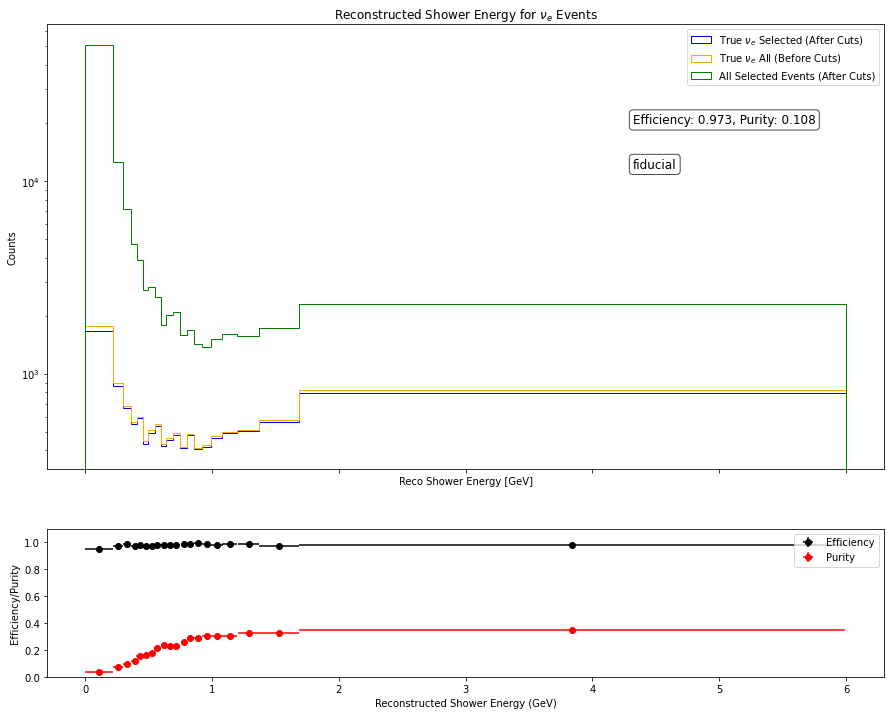

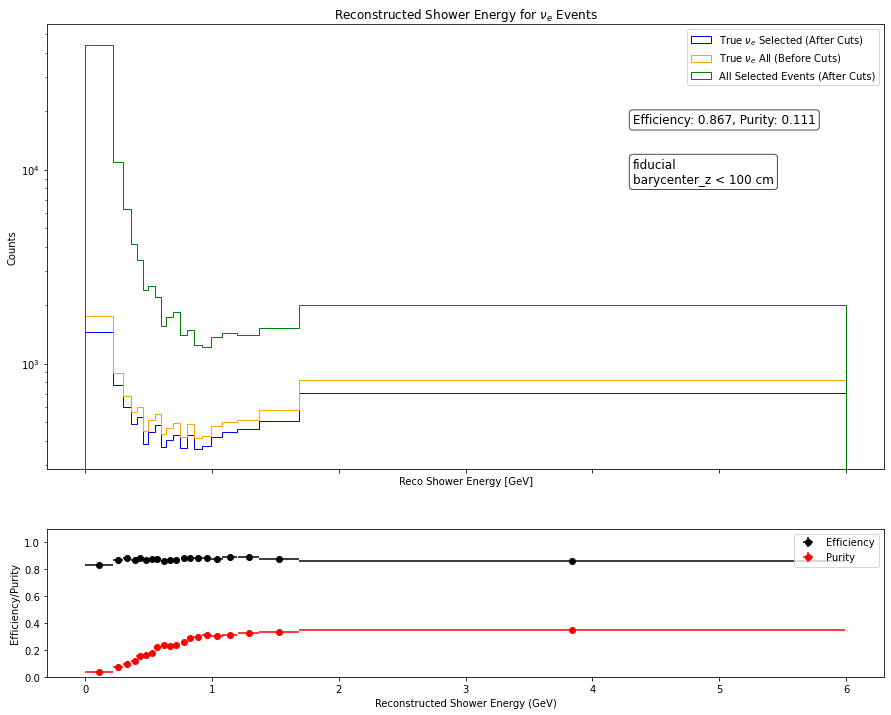

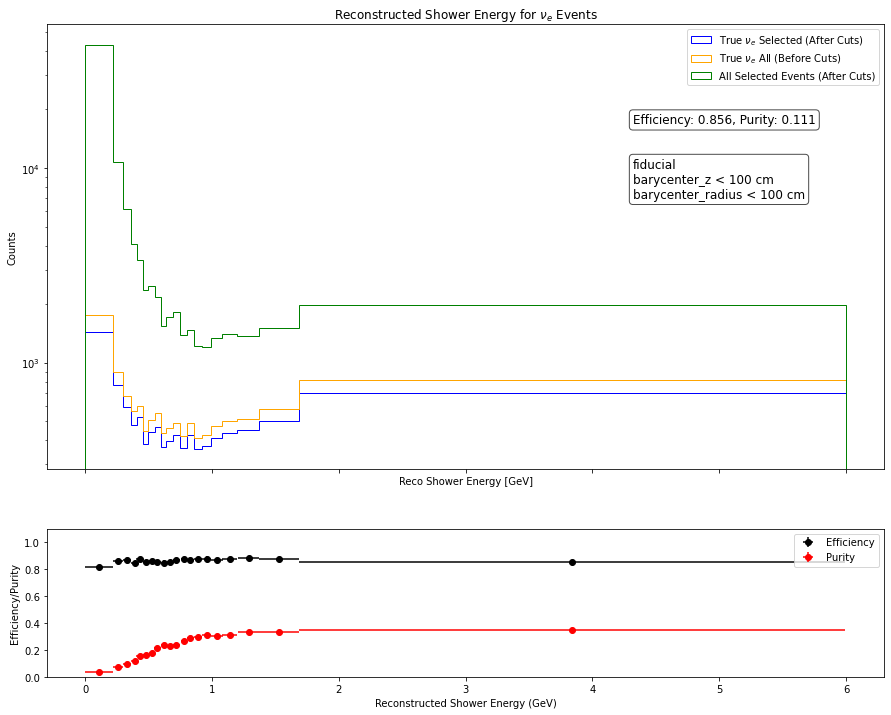

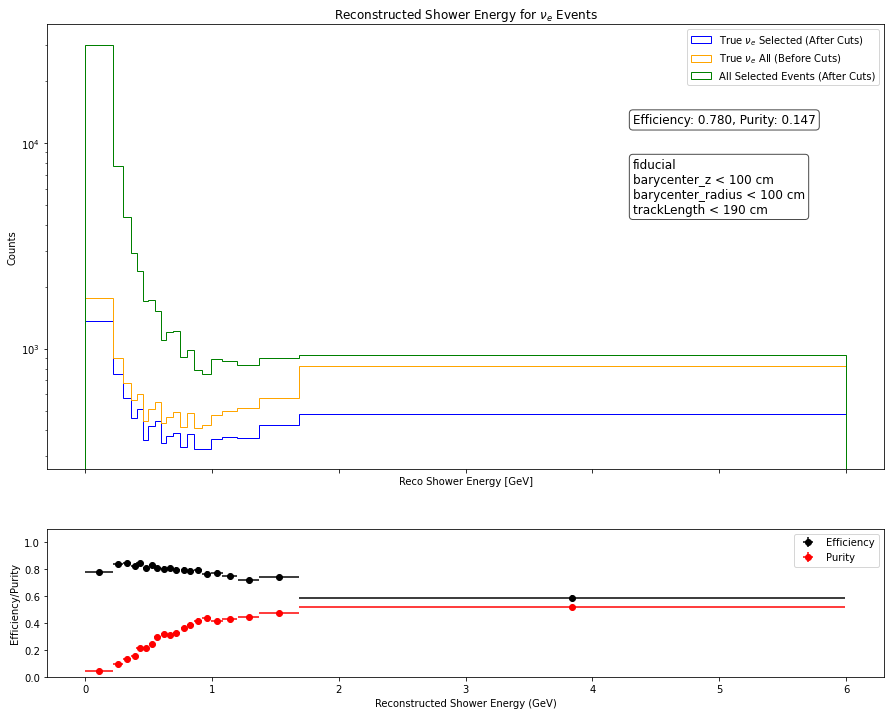

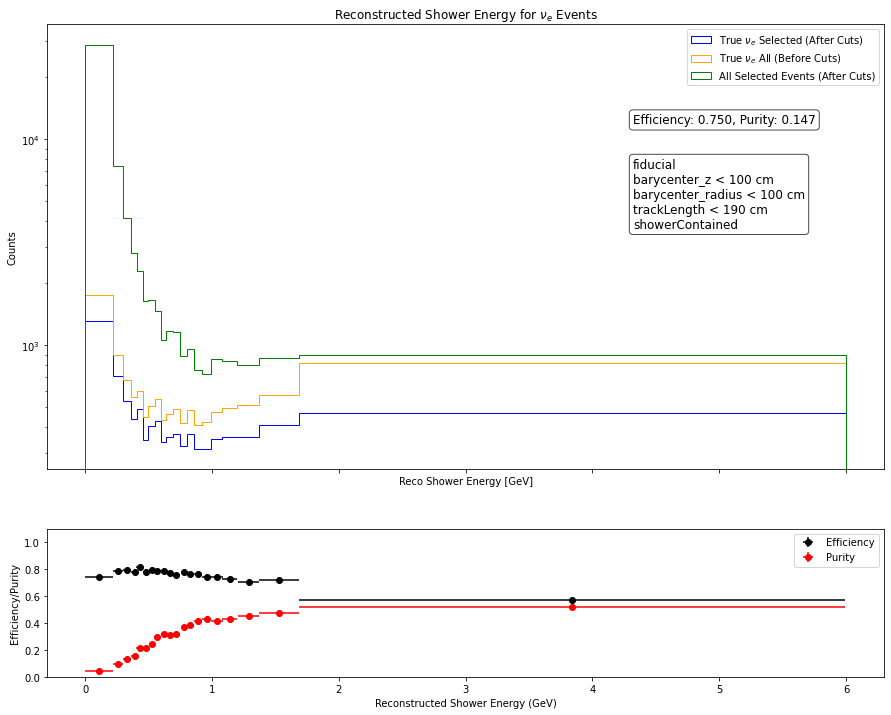

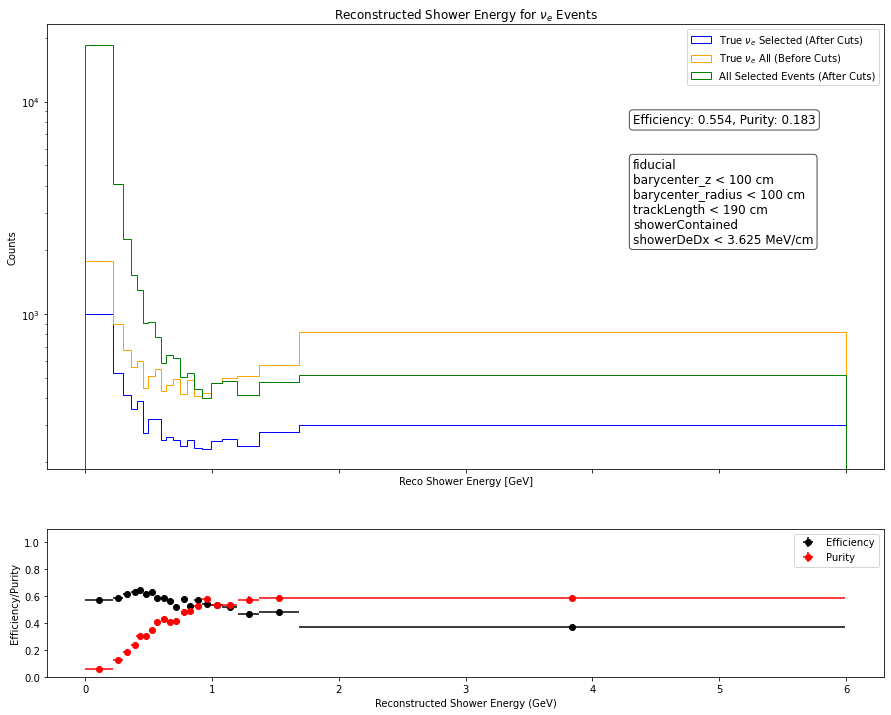

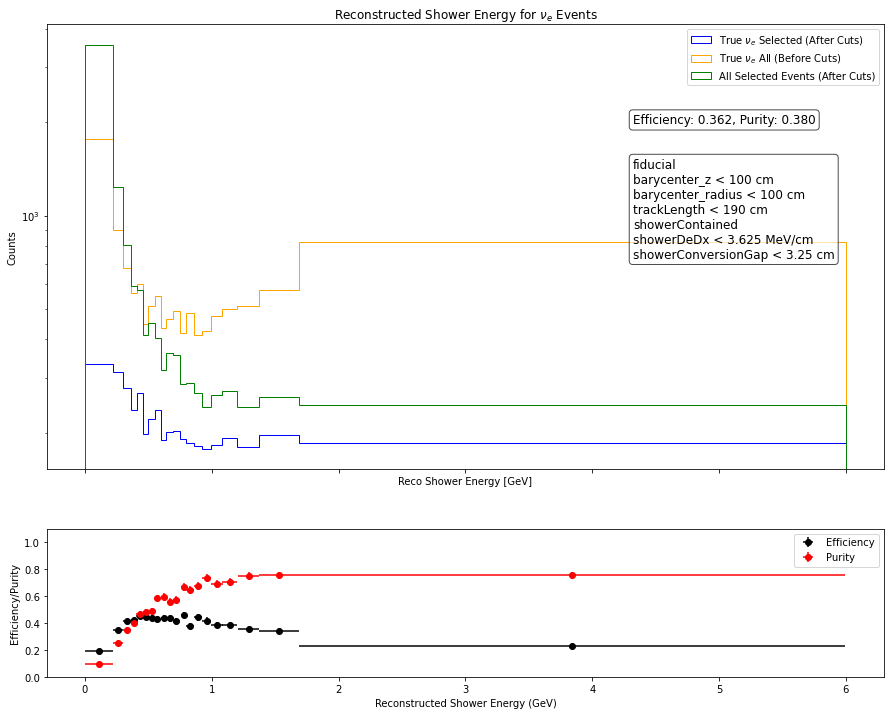

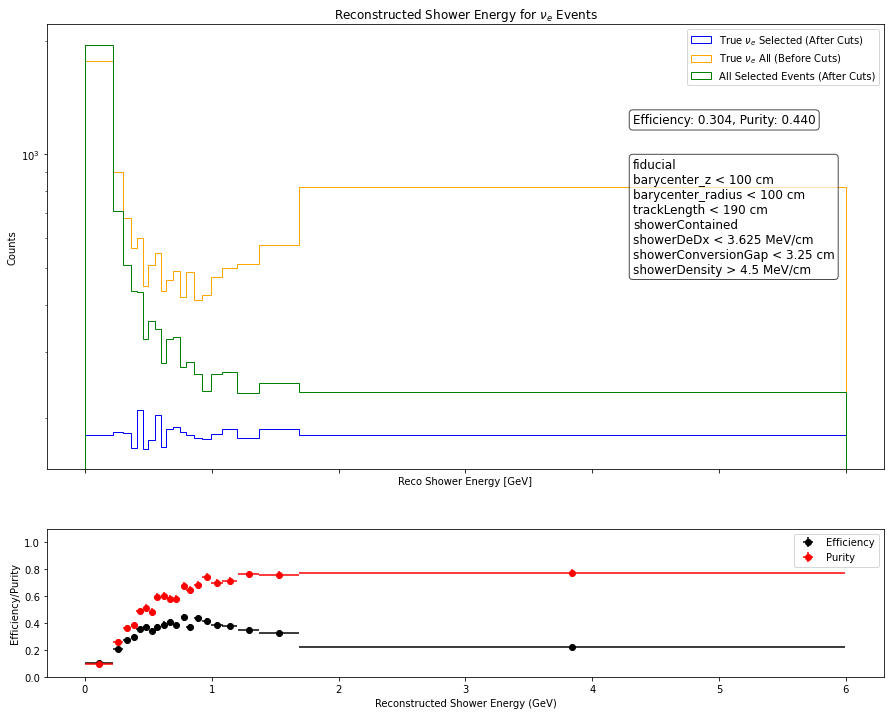

In [315]:
evtBins = [0.0, 0.22, 0.3, 0.36, 0.41, 0.46, \
    0.5, 0.55, 0.6, 0.64, 0.69, 0.75, 0.8, 
    0.86, 0.92, 0.99, 1.08, 1.2, 1.37, 1.69, 6.0] #optimized for constant selected nue events per bin

effBins = [0.0, 1.09, 1.14, 1.19, 1.25, \
    1.3, 1.35, 1.43, 1.62, 1.67, \
    1.72, 5.21, 5.26, 5.31, 5.36, \
    5.41, 5.46, 5.52, 5.61, 5.66, 6.0] #optimized for constant efficiency

selNue = initialCutsNuE
selAll = initialCutsAll
e_showerNue = f_all['rShowerEnergy'].array()[selNue]
sel_applied = []
for i, (key, val) in enumerate(selections.items()):
    print(f"Applying {key} cut:")
    selNue = selNue & val
    selAll = selAll & val
    sel_applied.append(key)
    e_shower_sel = f_all['rShowerEnergy'].array()[selNue]
    e_showerAll = f_all['rShowerEnergy'].array()[selAll]
    #getEffGraph(e_shower_sel, e_showerNue, [r'Reconstructed Shower Energy for $\nu_{e}$ Events', 'Reco Shower Energy [GeV]', 'Counts'], e_showerAll,(0, 6), 60, annotations=sel_applied)
    getEffGraphBins(e_shower_sel, e_showerNue, [r'Reconstructed Shower Energy for $\nu_{e}$ Events', 'Reco Shower Energy [GeV]', 'Counts'], e_showerAll, bins=evtBins, annotations=sel_applied)

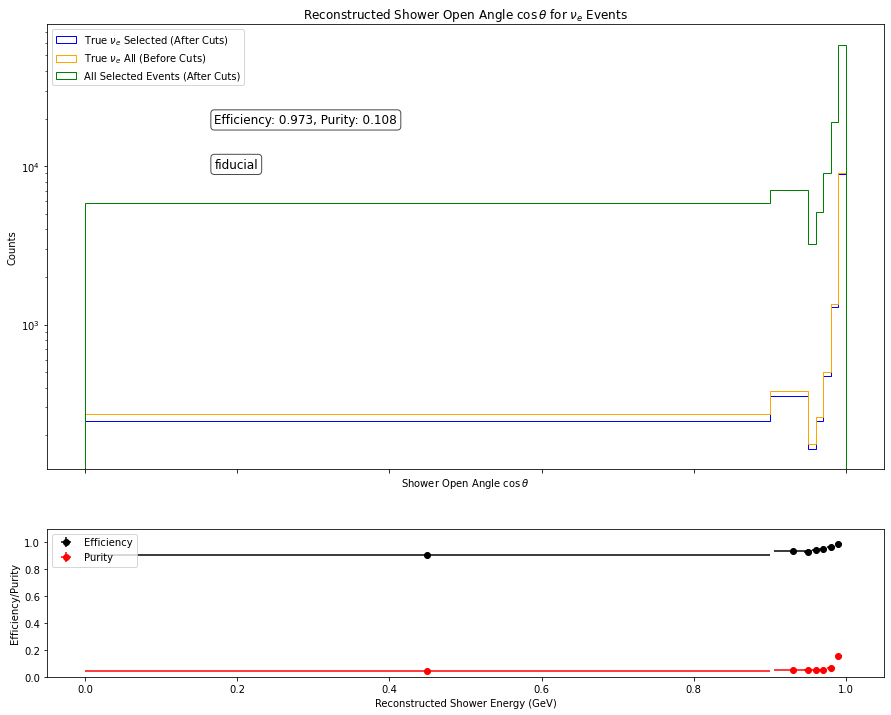

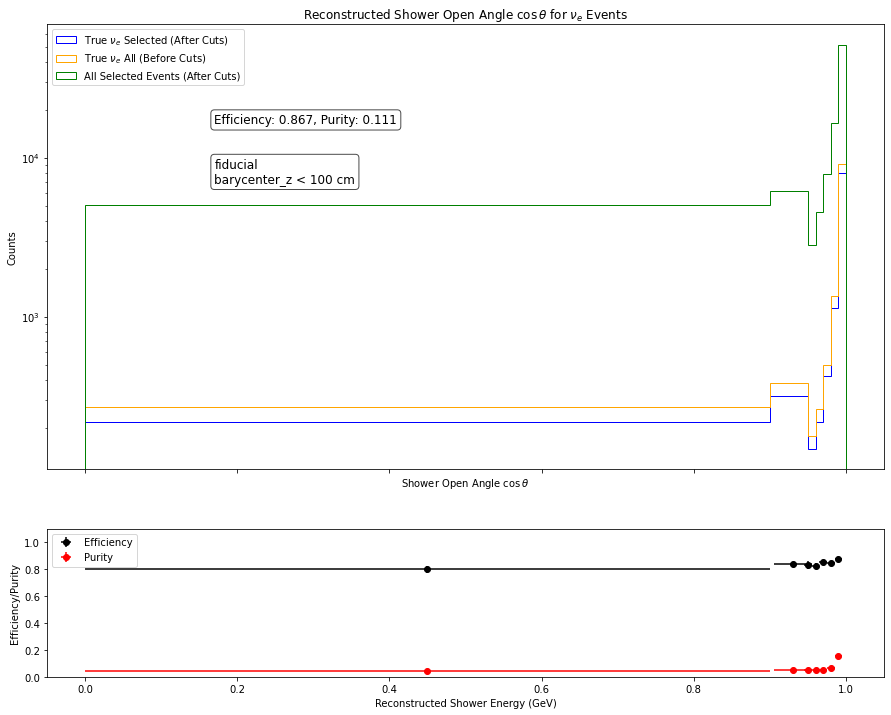

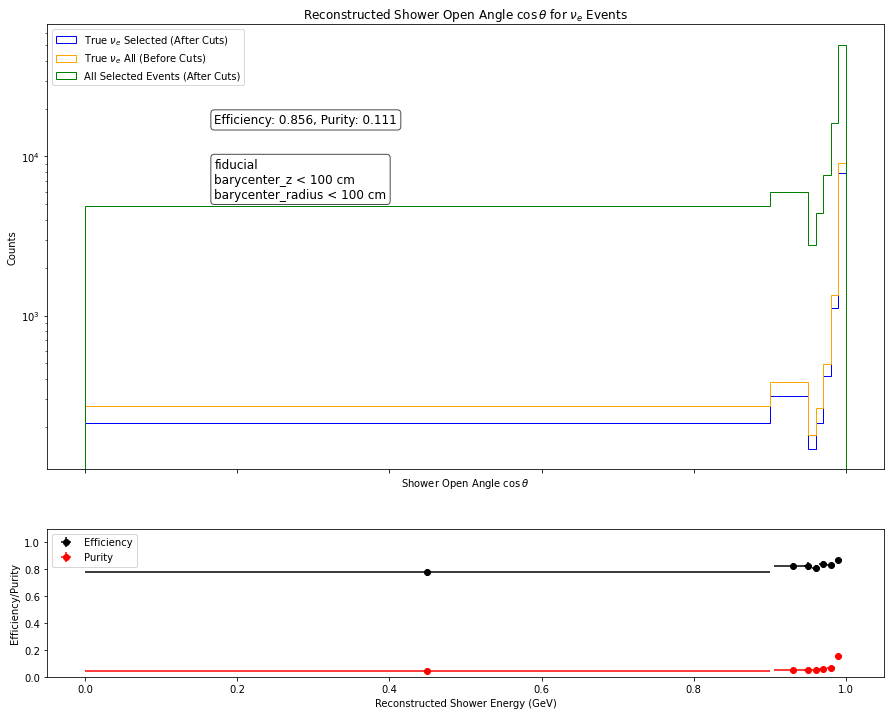

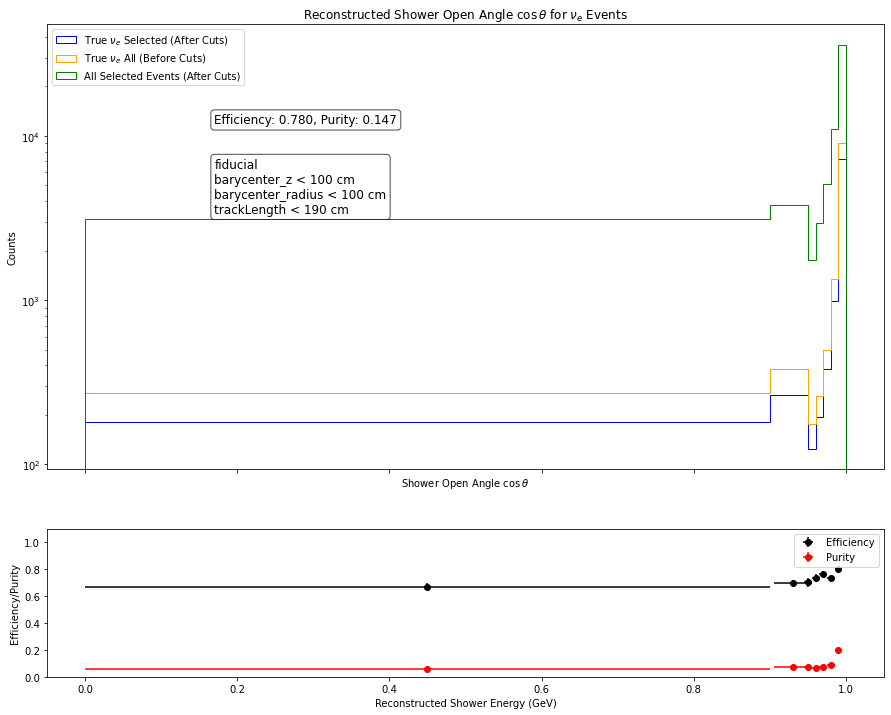

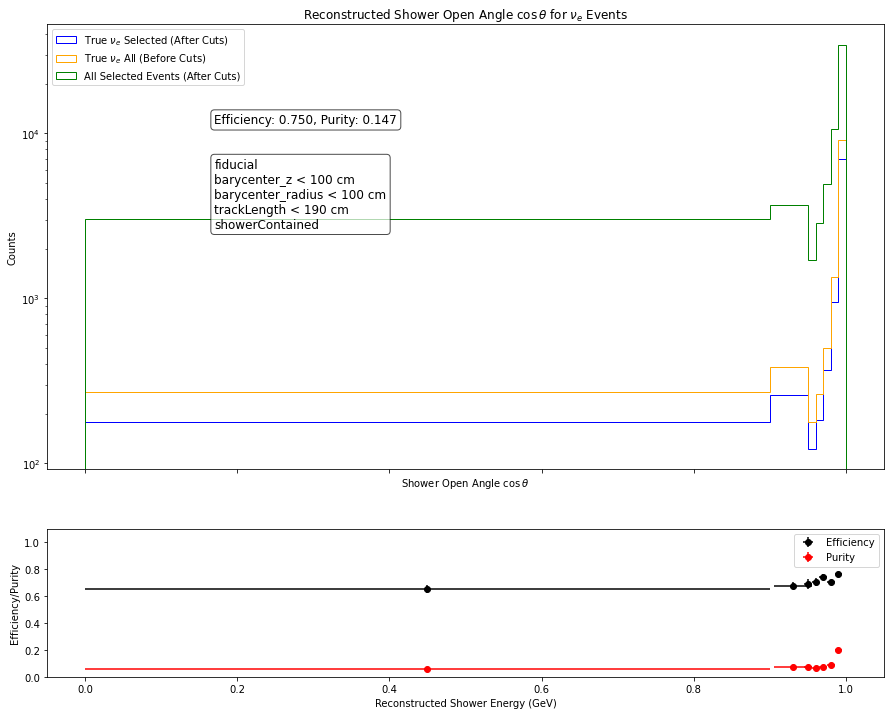

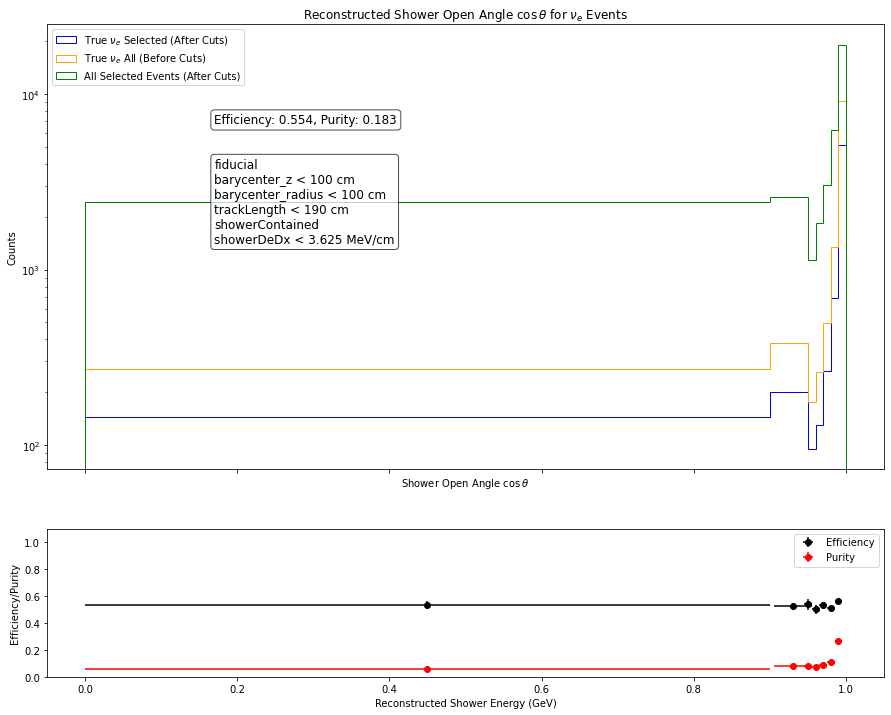

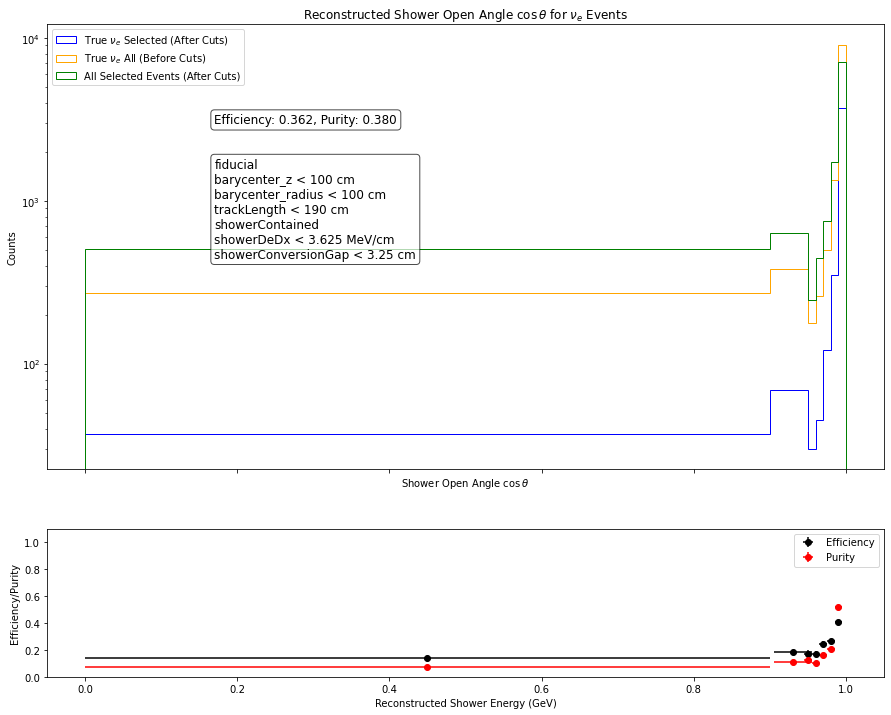

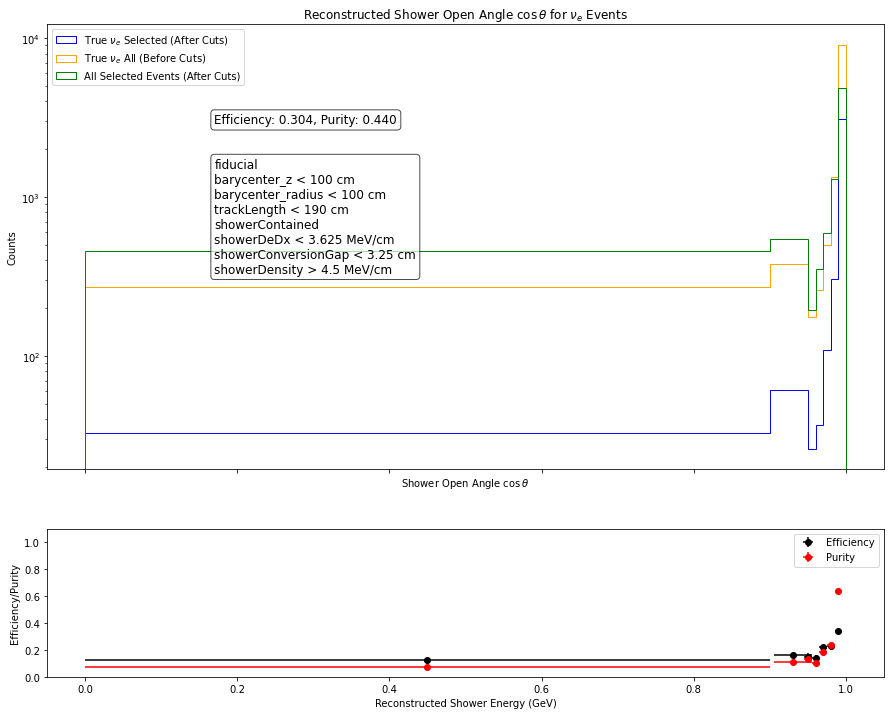

In [347]:
effBins = [0.0, 0.44, 1.0]

evtBins = [0.0, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]

selNue = initialCutsNuE
selAll = initialCutsAll
theta_showerNue = f_all['kShowerCosAngle'].array()[selNue]
sel_applied = []
theta_showerAll = f_all['kShowerCosAngle'].array()[selNue]
for i, (key, val) in enumerate(selections.items()):
    selNue = selNue & val
    selAll = selAll & val
    sel_applied.append(key)
    theta_shower_selNue = f_all['kShowerCosAngle'].array()[selNue]
    theta_shower_sel = f_all['kShowerCosAngle'].array()[selAll]
    #getEffGraph(theta_shower_selNue, theta_showerAll, [r"Reconstructed Shower Open Angle $\cos{\theta}$ for $\nu_{e}$ Events", r"Shower Open Angle $\cos{\theta}$", "Counts"], theta_shower_sel, (0, 1.2), 24, annotations=sel_applied, annPos=(0.2, 0.7))
    getEffGraphBins(theta_shower_selNue, theta_showerAll, [r"Reconstructed Shower Open Angle $\cos{\theta}$ for $\nu_{e}$ Events", r"Shower Open Angle $\cos{\theta}$", "Counts"], theta_shower_sel, bins=evtBins, annotations=sel_applied, annPos=(0.2, 0.7))


/tmp/ipykernel_24720/2396520045.py:21: RuntimeWarning: invalid value encountered in divide
  eff = h_num / h_den


Total true nue events after cuts: 3650
Total true nue events before cuts: 12024
Overall efficiency: 0.30355954757152365


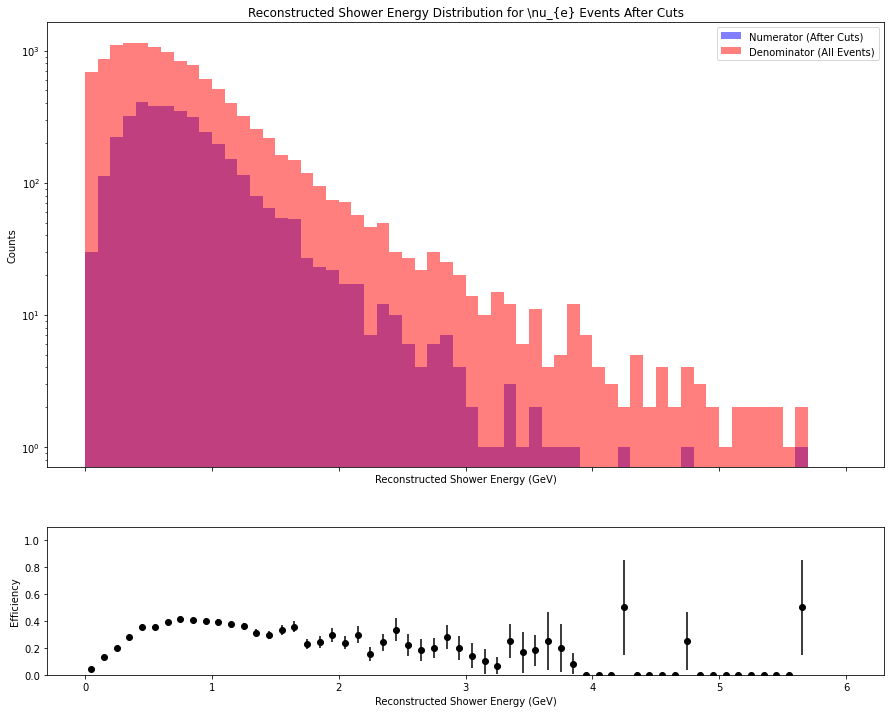

In [141]:
xlim = (0, 6)
nbins = 60

fig, (ax1, ax2) = plt.subplots(
    2, 1,               # 2 rows, 1 column
    gridspec_kw={'height_ratios': [3, 1]},  # top plot 3x taller than bottom
    sharex=True,         # share x-axis
    figsize=(15, 12)
)

ax1.hist(e_shower, bins=nbins, range=xlim, histtype='stepfilled', color='blue', alpha=0.5, label='Numerator (After Cuts)')
ax1.hist(e_showerAll, bins=nbins, range=xlim, histtype='stepfilled', color='red', alpha=0.5, label='Denominator (All Events)')
ax1.legend()
ax1.set_ylabel('Counts')
ax1.set_xlabel('Reconstructed Shower Energy (GeV)')
ax1.set_title(r'Reconstructed Shower Energy Distribution for \nu_{e} Events After Cuts')
ax1.set_yscale('log')

h_num = np.histogram(ak.to_numpy(e_shower), bins=nbins, range=xlim)[0]
h_den = np.histogram(ak.to_numpy(e_showerAll), bins=nbins, range=xlim)[0]
eff = h_num / h_den

npoints = (xlim[1] - xlim[0]) / nbins
points = np.linspace(xlim[0] + npoints/2, xlim[1] - npoints/2, nbins)
ax2.errorbar(points, eff, yerr=np.sqrt(eff * (1 - eff) / h_den), fmt='o', color='black')
ax2.set_ylim(0, 1.1)
ax2.set_ylabel('Efficiency')
ax2.set_xlabel('Reconstructed Shower Energy (GeV)')

print("Total true nue events after cuts:", len(e_shower))
print("Total true nue events before cuts:", len(e_showerAll))
print("Overall efficiency:", len(e_shower) / len(e_showerAll))

In [295]:
xlim = (2, 3)
nbins = 4
#bins = [0] + np.linspace(xlim[0], xlim[1], nbins+1).tolist()
# bins = np.linspace(0, 1, 11).tolist() + np.linspace(1, 3, 5).tolist() + [6.0]
# bins = np.unique(bins).tolist()

# bins = [0.0, 0.22, 0.3, 0.36, 0.41, 0.46, \
#     0.5, 0.55, 0.6, 0.64, 0.69, 0.75, 0.8, 
#     0.86, 0.92, 0.99, 1.08, 1.2, 1.37, 1.69, 6.0] #optimized for constant selected nue events per bin

bins = [0.0, 1.09, 1.14, 1.19, 1.25, \
    1.3, 1.35, 1.43, 1.62, 1.67, \
    1.72, 5.21, 5.26, 5.31, 5.36, \
    5.41, 5.46, 5.52, 5.61, 5.66, 6.0] #optimized for constant efficiency binning

print(bins)

h_num = r.TH1F('h_num', 'Numerator', len(bins)-1, arr('d', bins))
h_den = r.TH1F('h_den', 'Denominator', len(bins)-1, arr('d', bins))
h_allNue = r.TH1F('h_allNue', 'All True Nue', len(bins)-1, arr('d', bins))

sel = initialCutsAll
for key, val in selections.items():
    sel = sel & val
selNue = sel & (f_all['tNeutrinoType'].array() == 2)
e_showerAll = f_all['rShowerEnergy'].array()[sel]
e_showerNue = f_all['rShowerEnergy'].array()[selNue]
e_showerNueAll = f_all['rShowerEnergy'].array()[initialCutsNuE]
    
h_num.FillN(len(e_showerNue), arr('d', e_showerNue), np.ones(len(e_showerNue)))
h_den.FillN(len(e_showerAll), arr('d', e_showerAll), np.ones(len(e_showerAll)))
h_allNue.FillN(len(e_showerNueAll), arr('d', e_showerNueAll), np.ones(len(e_showerNueAll)))

g_eff = r.TGraphAsymmErrors(h_num, h_allNue)
g_pur = r.TGraphAsymmErrors(h_num, h_den)

h_num.Scale(1/h_num.Integral())
h_den.Scale(1/h_den.Integral())
h_allNue.Scale(1/h_allNue.Integral())

h_num.GetYaxis().SetRangeUser(1e-2, 1.1)
h_num.SetLineColor(r.kMagenta)
h_num.SetTitle("Reconstructed Shower Energy Distribution;Reconstructed Shower Energy (GeV);Normalized Events/Efficiency/Purity")
h_num.Draw("P")
h_den.SetLineColor(r.kBlue)
h_den.Draw("same P")
h_allNue.SetLineColor(r.kGreen+2)
h_allNue.Draw("same P")
g_eff.SetLineColor(r.kBlack)
g_eff.Draw("same P")
g_pur.SetLineColor(r.kRed)
g_pur.Draw("same P")

l1 = r.TLegend(0.6, 0.5, 0.9, 0.7)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(g_eff, "Efficiency", "lp")
l1.AddEntry(g_pur, "Purity", "lp")
l1.AddEntry(h_num, "Selected True #nu_{e}", "lp")
l1.AddEntry(h_den, "All Selected", "lp")
l1.AddEntry(h_allNue, "All True #nu_{e}", "lp")
l1.Draw()
r.gStyle.SetOptStat(0)

c1.SetLogy()
c1.Draw()




[0.0, 1.09, 1.14, 1.19, 1.25, 1.3, 1.35, 1.43, 1.62, 1.67, 1.72, 5.21, 5.26, 5.31, 5.36, 5.41, 5.46, 5.52, 5.61, 5.66, 6.0]


Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_num (Potential memory leak).
Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_den (Potential memory leak).
Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_allNue (Potential memory leak).
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 2 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 8 points have been skipped


In [285]:
print(len(bins))
c1.Draw()

31


In [334]:
import numpy as np

def weighted_hist_counts(values, edges, weights=None):
    """Return per-bin counts/weights and bin widths."""
    if weights is None:
        counts, _ = np.histogram(values, bins=edges)
    else:
        counts, _ = np.histogram(values, bins=edges, weights=weights)
    widths = np.diff(edges)
    return counts.astype(float), widths

def initial_edges_quantile(values, n_bins, weights=None, left=None, right=None, min_width=None):
    """Return initial quantile-based edges (weighted or not), optionally enforcing a minimum bin width."""
    values = np.asarray(values)
    if values.size == 0 or n_bins < 1:
        raise ValueError("values must be non-empty and n_bins >= 1")

    if weights is None:
        qs = np.linspace(0, 1, n_bins + 1)
        edges = np.quantile(values, qs)
    else:
        sorter = np.argsort(values)
        v = values[sorter]
        w = np.asarray(weights, dtype=float)[sorter]
        cumw = np.cumsum(w)
        total = cumw[-1]
        if total <= 0:
            raise ValueError("Sum of weights must be positive")
        cumw_norm = cumw / total
        qs = np.linspace(0, 1, n_bins + 1)
        edges = np.interp(qs, np.hstack(([0.0], cumw_norm)), np.hstack((v[0], v)))

    if left is not None:
        edges[0] = float(left)
    if right is not None:
        edges[-1] = float(right)

    # Enforce minimum bin width if requested
    if min_width is not None and min_width > 0:
        span = float(edges[-1] - edges[0])
        if span <= 0:
            raise ValueError("Right edge must be greater than left edge to enforce min_width")
        # Cap the effective min width to be feasible
        eff_min = min(float(min_width), span / n_bins)

        new_edges = [float(edges[0])]
        for k in range(1, n_bins):
            # At least eff_min from previous
            candidate = float(edges[k])
            edge_k = max(candidate, new_edges[-1] + eff_min)
            # Leave room for remaining bins to have >= eff_min
            max_allowed = edges[-1] - eff_min * (n_bins - k)
            edge_k = min(edge_k, max_allowed)
            new_edges.append(edge_k)
        new_edges.append(float(edges[-1]))
        edges = np.array(new_edges, dtype=float)

    return np.array(edges, dtype=float)

def initial_edges_from_event_arrays(x_den, x_num, n_bins,
                                    left=0, right=6, min_width=0.01,
                                    weights_den=None, weights_num=None):
    """
    Build `n_bins` bin edges in `x` (returned as length n_bins+1 array) so that the
    efficiency per bin (sum(weights_num_in_bin) / sum(weights_den_in_bin)) is
    approximately the global efficiency.

    This function accepts two event-array inputs:
      - `x_den`: values for denominator events (all trials)
      - `x_num`: values for numerator events (successful trials). Typically these
        are a subset of `x_den` (same value recorded for the same event).

    The routine aggregates identical x-values (so repeated identical values are
    handled), computes per-unique-x numerator and denominator totals, then
    greedily groups adjacent unique-x cells until each output bin's efficiency
    reaches the global efficiency target. It enforces `min_width` and respects
    optional `left`/`right` bounds.

    Important assumptions and notes:
    - `x_num` elements should correspond to a subset of `x_den` values (exact
      equality). If floating point rounding prevents exact matches, consider
      pre-binning your data into small input bins and use the histogram-based
      helper instead.
    - If weights are not provided, events are counted with weight=1.
    - If total denominator weight inside [left, right] is zero the function
      returns uniform edges between left and right.

    Parameters
    ----------
    x_den, x_num : array-like
        Arrays of values (same physical variable). x_num usually a subset of x_den.
    n_bins : int
        Desired number of output bins.
    left, right : float or None
        Optional bounding edges. If None they are taken from min/max of x_den.
    min_width : float
        Minimum allowed bin width (in x units).
    weights_den, weights_num : array-like or None
        Optional per-event weights corresponding to x_den and x_num respectively.

    Returns
    -------
    edges : ndarray, shape (n_bins+1,)
        The bin edges (left to right).
    """
    x_den = np.asarray(x_den)
    x_num = np.asarray(x_num)
    if weights_den is None:
        w_den = np.ones_like(x_den, dtype=float)
    else:
        w_den = np.asarray(weights_den, dtype=float)
    if weights_num is None:
        w_num = np.ones_like(x_num, dtype=float)
    else:
        w_num = np.asarray(weights_num, dtype=float)

    if left is None:
        if x_den.size == 0:
            raise ValueError("x_den is empty and left is None")
        left = float(np.nanmin(x_den))
    if right is None:
        if x_den.size == 0:
            raise ValueError("x_den is empty and right is None")
        right = float(np.nanmax(x_den))
    if right <= left:
        raise ValueError("right must be > left")

    # Filter denominator events to [left, right]
    mask_den = (x_den >= left) & (x_den <= right)
    x_den_f = x_den[mask_den]
    w_den_f = w_den[mask_den]

    # Filter numerator events to [left, right]
    mask_num = (x_num >= left) & (x_num <= right)
    x_num_f = x_num[mask_num]
    w_num_f = w_num[mask_num]

    # If no denominator events, return uniform edges
    if x_den_f.size == 0:
        return np.linspace(left, right, n_bins + 1)

    # Build combined array and tag which entries are den vs num so we can aggregate
    # identical x values robustly (handles duplicates correctly).
    x_all = np.concatenate([x_den_f, x_num_f])
    wden_all = np.concatenate([w_den_f, np.zeros_like(w_num_f)])
    wnum_all = np.concatenate([np.zeros_like(w_den_f), w_num_f])

    order = np.argsort(x_all)
    x_s = x_all[order]
    wden_s = wden_all[order]
    wnum_s = wnum_all[order]

    # Aggregate consecutive equal x values into unique bins
    # Using exact equality; if your data has floating rounding differences, pre-bin first.
    if x_s.size == 0:
        return np.linspace(left, right, n_bins + 1)

    # find boundaries where value changes
    change = np.nonzero(np.concatenate(([1], x_s[1:] != x_s[:-1].view(x_s.dtype))))[0]
    # alternate approach to be safe: build idx of group starts
    # We'll iterate accumulating until value changes
    uniq_x = []
    uniq_den = []
    uniq_num = []
    start = 0
    N_all = x_s.size
    for i in range(1, N_all):
        if x_s[i] != x_s[i - 1]:
            uniq_x.append(x_s[start])
            uniq_den.append(np.sum(wden_s[start:i]))
            uniq_num.append(np.sum(wnum_s[start:i]))
            start = i
    # last group
    uniq_x.append(x_s[start])
    uniq_den.append(np.sum(wden_s[start:N_all]))
    uniq_num.append(np.sum(wnum_s[start:N_all]))

    uniq_x = np.asarray(uniq_x, dtype=float)
    uniq_den = np.asarray(uniq_den, dtype=float)
    uniq_num = np.asarray(uniq_num, dtype=float)

    # If no denominator mass (shouldn't happen) return uniform
    if uniq_den.sum() == 0:
        return np.linspace(left, right, n_bins + 1)

    target_eff = uniq_num.sum() / uniq_den.sum()

    edges = [left]
    i = 0
    M = uniq_x.size

    for k in range(n_bins - 1):
        remaining_bins = n_bins - k
        remaining_groups = M - i
        if remaining_groups <= 0:
            break
        max_j = M - (remaining_bins - 1) - 1
        if max_j < i:
            max_j = i

        sum_num = 0.0
        sum_den = 0.0
        j = i
        cut_j = None
        start_x = uniq_x[i]
        while j <= max_j:
            sum_num += uniq_num[j]
            sum_den += uniq_den[j]
            bin_eff = (sum_num / sum_den) if sum_den > 0 else 0.0
            width = uniq_x[j] - start_x
            if (bin_eff >= target_eff and (width >= min_width or j == max_j)):
                cut_j = j
                break
            j += 1
        if cut_j is None:
            cut_j = max_j

        # place edge between group cut_j and cut_j+1
        if cut_j + 1 < M:
            edge = 0.5 * (uniq_x[cut_j] + uniq_x[cut_j + 1])
        else:
            edge = min(right, uniq_x[cut_j] + 1e-9 * max(1.0, abs(uniq_x[cut_j])))

        # enforce min_width relative to last edge
        if edge - edges[-1] < min_width:
            edge = edges[-1] + min_width
            edge = min(edge, right - (n_bins - k - 1) * min_width)

        edges.append(float(edge))
        i = cut_j + 1
        if i >= M:
            break

    edges.append(right)
    edges = np.array(edges, dtype=float)

    # fix up if too few edges
    if len(edges) < n_bins + 1:
        last = edges[-1]
        need = n_bins + 1 - len(edges)
        if last < right:
            extra = np.linspace(last, right, need + 1)[1:]
        else:
            extra = np.repeat(right, need)
        edges = np.concatenate([edges, extra])

    if len(edges) > n_bins + 1:
        edges = np.linspace(edges[0], edges[-1], n_bins + 1)

    return edges

Initial edges: [0.   0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]
Initial max dev: 2620.75


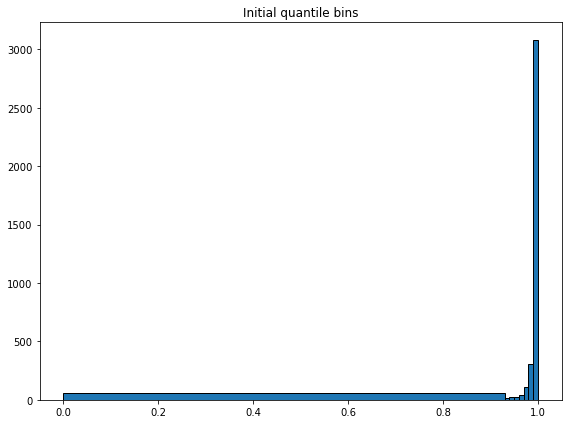

[0.0, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]


In [351]:
#optimizing for equal number of selected signal events

# example data (replace with your actual values and weights)
vals = theta_shower_selNue
w = None  # or weights array

# start with quantile edges
init_edges = initial_edges_quantile(vals, n_bins=8, weights=w, left=0.0, right=1.0, min_width=0.01)

print("Initial edges:", init_edges)
counts_init, _ = np.histogram(vals, bins=init_edges, weights=w)
print("Initial max dev:", np.max(np.abs(counts_init - counts_init.mean())))

fig, axs = plt.subplots(1,1,figsize=(8,6), sharex=True)
axs.hist(vals, bins=init_edges, weights=w, edgecolor='k')
axs.set_title("Initial quantile bins")
plt.tight_layout()
plt.show()

edges = [round(x, 2) for x in init_edges]
print(edges)

In [339]:
#optimizing for efficiency

edges = initial_edges_from_event_arrays(theta_showerNue, theta_shower_selNue, n_bins=3, right=1.1, min_width=0.1)
print('edges:', edges)
edges = [round(x, 2) for x in edges]
print(edges)
h_num = np.histogram(e_showerNue, bins=np.array(edges))
h_den = np.histogram(e_showerNueAll, bins=np.array(edges))
eff = np.divide(h_num[0], h_den[0], out=np.full_like(h_num[0], np.nan, dtype=float), where=h_den[0] > 0)
print("Efficiency per bin:", eff)

edges: [0.         0.44133936 0.99994735 1.1       ]
[0.0, 0.44, 1.0, 1.1]
Efficiency per bin: [1. 1. 1.]


## Old Code Saved for Future Use

In [78]:
a_nuTypes = f_raw['tNeutrinoType'].array()
a_intTypes = f_raw['tInteractionMode'].array()

selectionCuts = f_raw['rFiducial'].array() == 1 #fiducial cut
selectionCuts = selectionCuts & (f_raw['rBarycenterDeltaZ'].array() < 100) & (f_raw['rBarycenterDeltaZ'].array() >= 0) #barycenter cut
selectionCuts = selectionCuts &  (f_raw['rBarycenterRadius'].array() < 100) & (f_raw['rBarycenterRadius'].array() >= 0) #barycenter cut
selectionCuts = selectionCuts & (f_raw['rLongestTrackLength'].array() < 190) #longest track cut
selectionCuts = selectionCuts & (f_raw['rShowerContained'].array() == 1) #shower contained cut
#selectionCuts = selectionCuts & (f_raw['rShowerEnergy'].array() > 0.5) #shower energy cut
selectionCuts = selectionCuts & (f_raw['rShowerDeDx'].array() < 3.625) #shower dedx cut
selectionCuts = selectionCuts & (f_raw['rShowerConversionGap'].array() < 3.25) #shower conversion gap cut
selectionCuts = selectionCuts & (f_raw['rShowerDensity'].array() > 4.5) #shower density cut

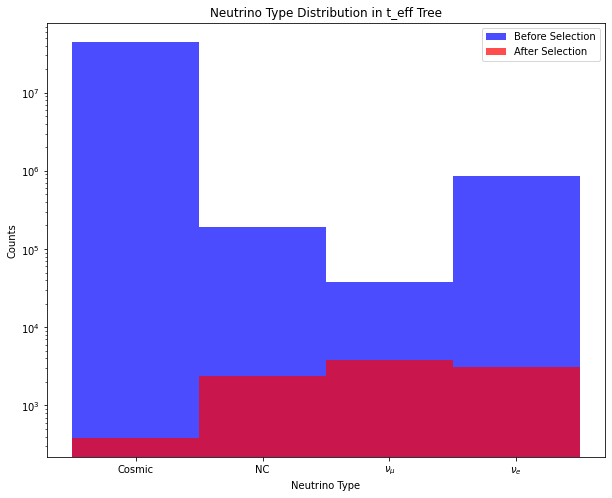

In [ ]:
nu_types = [r'Cosmic', r'NC', r'$\nu_{e}$', r'$\nu_{\mu}$']
plt.figure(figsize=(10, 8))


plt.hist(a_nuTypes, bins=range(0, len(nu_types) + 1), histtype='stepfilled', color='blue', alpha=0.5)
plt.hist(a_nuTypes[selectionCuts], bins=range(0, len(nu_types) + 1), histtype='stepfilled', color='red', alpha=0.5)
plt.legend(['Before Selection', 'After Selection'])
plt.xticks(np.arange(0, len(nu_types)) + 0.5, nu_types)
plt.xlabel("Neutrino Type")
plt.ylabel("Counts")
plt.title("Neutrino Type Distribution in t_eff Tree")
plt.yscale('log')
plt.show()

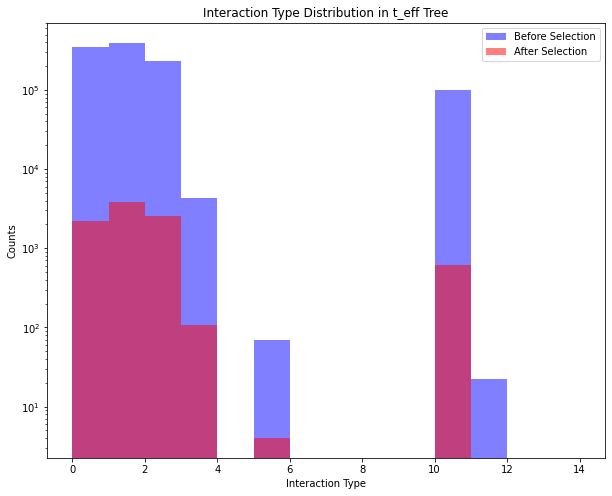

In [81]:
#nu_types = [r'Cosmic', r'NC', r'$\nu_{\mu}$', r'$\nu_{e}$']
#https://github.com/SBNSoftware/sbnanaobj/blob/0fb95094a2ea457c363b1e3d4b2fada9e9cca4db/sbnanaobj/StandardRecord/SREnums.h#L76
    # kUnknownInteractionMode    =   -1,
    # kQE                        =    0,
    # kRes                       =    1,
    # kDIS                       =    2,
    # kCoh                       =    3,
    # kCohElastic                =    4,
    # kElectronScattering        =    5,
    # kIMDAnnihilation           =    6,
    # kInverseBetaDecay          =    7,
    # kGlashowResonance          =    8,
    # kAMNuGamma                 =    9,
    # kMEC                       =   10,
    # kDiffractive               =   11,
    # kEM                        =   12,
    # kWeakMix                   =   13

int_types = [r'QE', r'Res', r'DIS', r'Coh', r'CohElastic', r'ElectronScattering', r'IMDAnnihilation', r'InverseBetaDecay', r'GlashowResonance', r'AMNuGamma', r'MEC', r'Diffractive', r'EM', r'WeakMix']
plt.figure(figsize=(10, 8))



plt.hist(a_intTypes, bins=range(0, len(int_types) + 1), histtype='stepfilled', color='blue', alpha=0.5)
plt.hist(a_intTypes[selectionCuts], bins=range(0, len(int_types) + 1), histtype='stepfilled', color='red', alpha=0.5)
plt.legend(['Before Selection', 'After Selection'])
#plt.xticks(np.arange(0, len(nu_types)) + 0.5, nu_types)
plt.xlabel("Interaction Type")
plt.ylabel("Counts")
plt.title("Interaction Type Distribution in t_eff Tree")
plt.yscale('log')
plt.show()

Total true nue events after cuts: 239
Total true nue events before cuts: 151075
Overall efficiency: 0.0015819956975012411


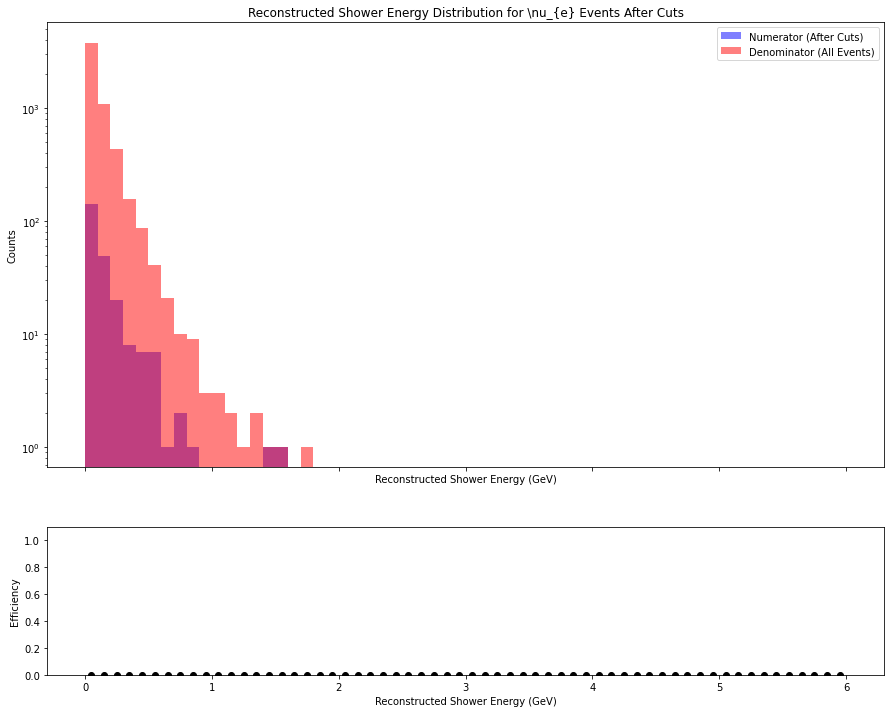

In [86]:
xlim = (0, 6)
nbins = 60

fig, (ax1, ax2) = plt.subplots(
    2, 1,               # 2 rows, 1 column
    gridspec_kw={'height_ratios': [3, 1]},  # top plot 3x taller than bottom
    sharex=True,         # share x-axis
    figsize=(15, 12)
)
true_nue = (a_nuTypes == 3) & (f_raw['tInteractionMode'].array() == 0)
a_shwE = f_raw['rShowerEnergy'].array()
e_nue = a_shwE[true_nue & selectionCuts]

all_true_nue = (f_raw['tNeutrinoType'].array() == 3) & (f_raw['rFiducial'].array() == 1) & (f_raw['tInteractionMode'].array() == 0)
e_other = f_raw['rShowerEnergy'].array()[all_true_nue]

ax1.hist(e_nue, bins=nbins, range=xlim, histtype='stepfilled', color='blue', alpha=0.5, label='Numerator (After Cuts)')
ax1.hist(e_other, bins=nbins, range=xlim, histtype='stepfilled', color='red', alpha=0.5, label='Denominator (All Events)')
ax1.legend()
ax1.set_ylabel('Counts')
ax1.set_xlabel('Reconstructed Shower Energy (GeV)')
ax1.set_title(r'Reconstructed Shower Energy Distribution for \nu_{e} Events After Cuts')
ax1.set_yscale('log')

h_num = np.histogram(ak.to_numpy(e_nue), bins=nbins, range=xlim)[0]
h_den = np.histogram(ak.to_numpy(a_shwE), bins=nbins, range=xlim)[0]
eff = h_num / h_den

npoints = (xlim[1] - xlim[0]) / nbins
points = np.linspace(xlim[0] + npoints/2, xlim[1] - npoints/2, nbins)
ax2.errorbar(points, eff, yerr=np.sqrt(eff * (1 - eff) / h_den), fmt='o', color='black')
ax2.set_ylim(0, 1.1)
ax2.set_ylabel('Efficiency')
ax2.set_xlabel('Reconstructed Shower Energy (GeV)')

print("Total true nue events after cuts:", len(e_nue))
print("Total true nue events before cuts:", len(e_other))
print("Overall efficiency:", len(e_nue) / len(e_other))

In [121]:
c1 = r.TCanvas("c1", "c1", 800, 600)

h_showerE = r.TH1F("h_showerE", "Reconstructed Shower Energy;Shower Energy (GeV);Counts", 60, 0, 6)
a_showerE_all = arr('d', ak.flatten(f_raw['rShowerEnergy'].array(), axis=-1))
h_showerE.FillN(len(a_showerE_all), a_showerE_all, np.ones(len(a_showerE_all)))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h_showerE (Potential memory leak).


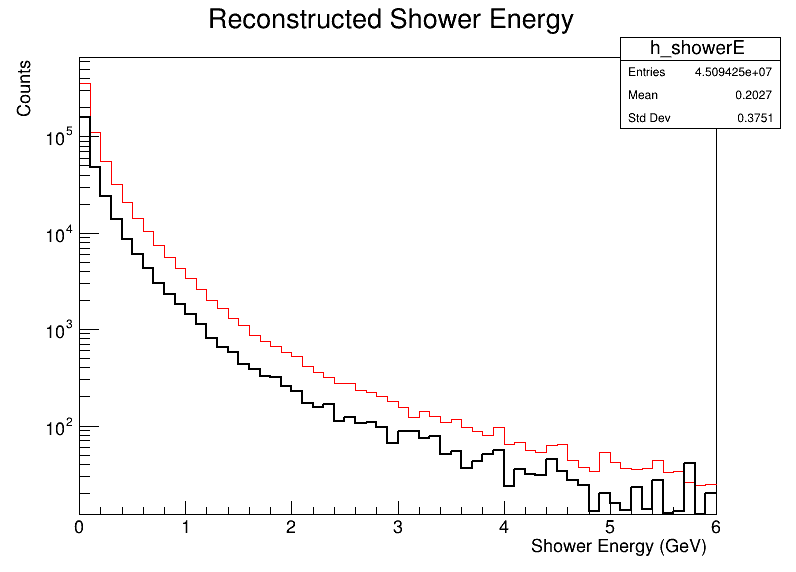

In [125]:
h_showerE.SetLineColor(r.kRed)
h_showerE.Draw("hist")
s_all['seqNoCut_rShowerEnergy'].hist.Draw("same hist")

c1.SetLogy()
c1.Draw()

h_den.GetMaximum() 146909.40000000002
h_num.GetMaximum() 10000.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


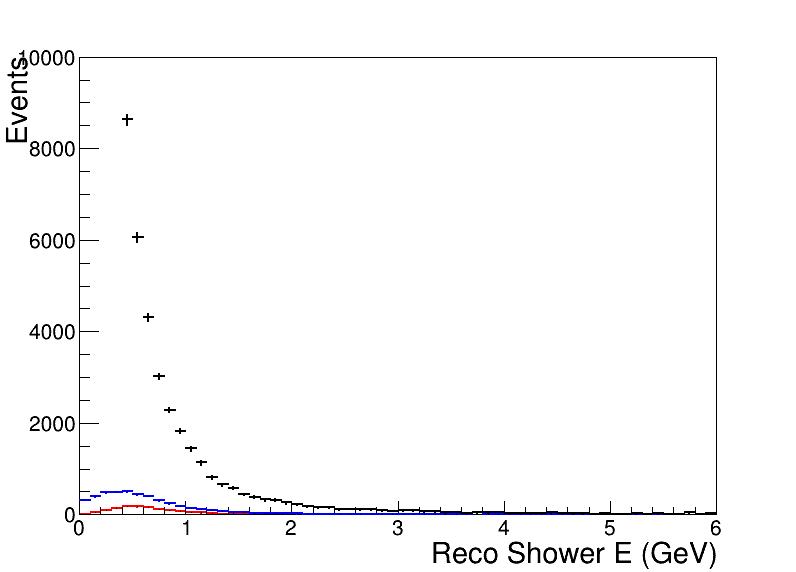

In [117]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = n_nueEff['nm1ShowerEnergy_rShowerEnergy'].hist.Clone()
h_den = s_nueEff['seqNoCut_rShowerEnergy'].hist.Clone()
h_num.GetYaxis().SetRangeUser(0, 10000)
h_num.SetLineColor(r.kRed)
h_num.Draw()
h_den.Draw("same")
s_all['seqNoCut_rShowerEnergy'].hist.Draw("same")

c1.Draw()

print("h_den.GetMaximum()", h_den.GetMaximum())
print("h_num.GetMaximum()", h_num.GetMaximum())

Total selected nue events: 1347.4590918747174
Total true nue events: 5301.805617103076
Efficiency: 0.25415097972056044
Purity: 0.36501739492236196


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 6 points have been skipped


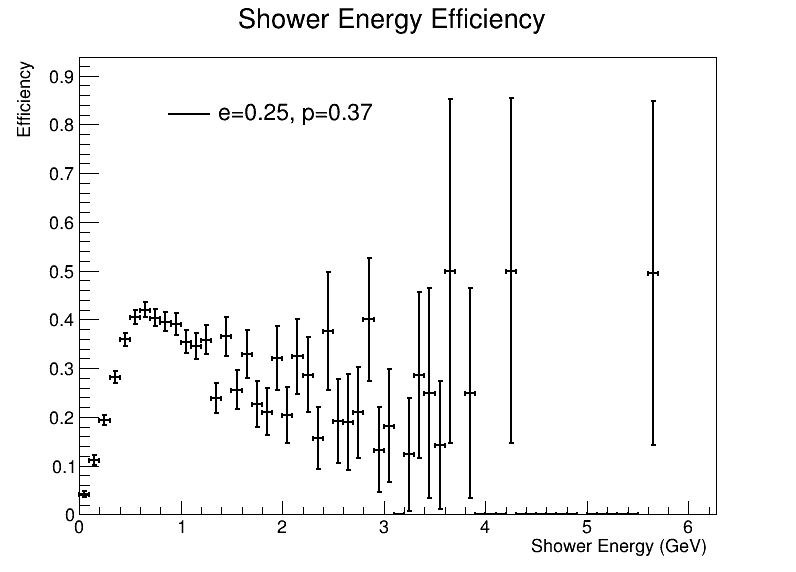

In [85]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = n_nueEff['nm1ShowerEnergy_rShowerEnergy'].hist.Clone()
h_den = s_nueEff['seqNoCut_rShowerEnergy'].hist.Clone()
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower Energy Efficiency;Shower Energy (GeV);Efficiency")
g_eff.SetLineColor(r.kBlack)
g_eff.Draw("AP")

totalNue = s_trueE['seqNoCut_NumNuE'].integral
eff = n_nueEff['nm1ShowerEnergy_rFiducial'].integral / totalNue

purity = n_nueEff['nm1ShowerEnergy_rFiducial'].integral / n_all['nm1ShowerEnergy_rFiducial'].integral

l1 = r.TLegend(0.2, 0.7, 0.5, 0.9)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(g_eff, f"e={eff:.2f}, p={purity:.2f}", "lp")
l1.Draw()

c1.Draw()

print("Total selected nue events:", n_nueEff['nm1ShowerEnergy_rFiducial'].integral)
print("Total true nue events:", totalNue)
print("Efficiency:", eff)
print("Purity:", purity)

### Check anti electron neutrino concentration in RHC vs FHC

In [33]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcRHC/mc.root")

c1 = r.TCanvas("c1", "c1", 1000, 700)

%jsroot off

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


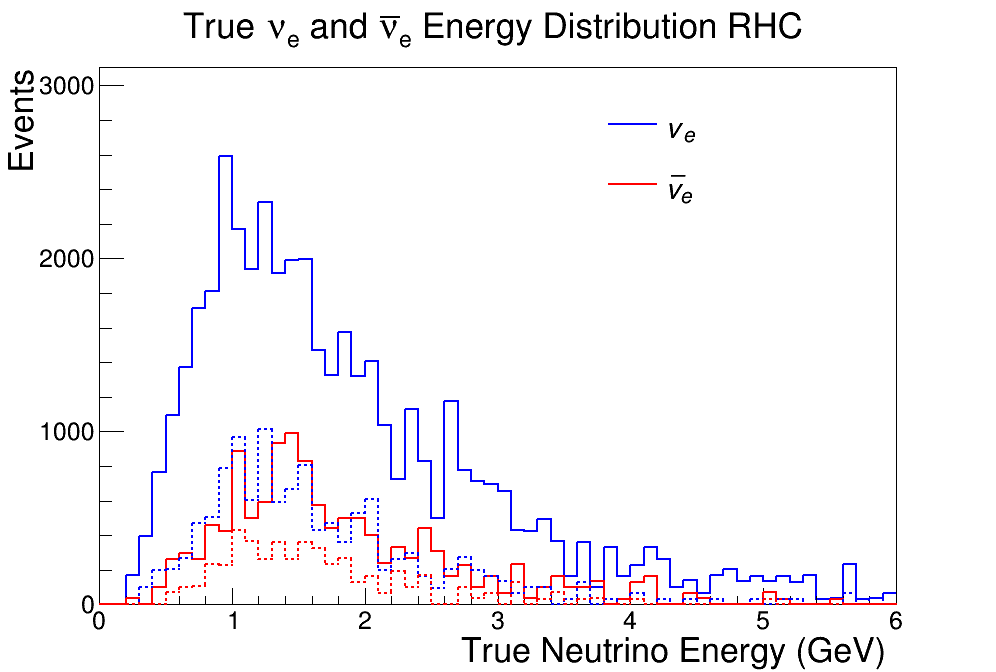

In [34]:
h_nue = fin.Get("nueP/seqPlots/seqNoCut_tNueEnergy")
h_anue = fin.Get("nueA/seqPlots/seqNoCut_tNueEnergy")

# h_nueCut = fin.Get("nueP/seqPlots/seqShowerDensity_tNueEnergy")
# h_anueCut = fin.Get("nueA/seqPlots/seqShowerDensity_tNueEnergy")
h_nueCut = fin.Get("nueP/nm1Plots/nm1ShowerEnergy_tNueEnergy")
h_anueCut = fin.Get("nueA/nm1Plots/nm1ShowerEnergy_tNueEnergy")

h_nue.SetLineColor(r.kBlue)
h_nue.SetLineWidth(2)
h_anue.SetLineColor(r.kRed)
h_anue.SetLineWidth(2)

max_hist = max(h_nue.GetMaximum(), h_anue.GetMaximum())
h_nue.SetMaximum(max_hist * 1.2)
h_nue.SetMinimum(0)

l1 = r.TLegend(0.6, 0.68, 0.88, 0.86)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(h_nue, r"\nu_e", "l")
l1.AddEntry(h_anue, r"\bar{\nu}_e", "l")

h_nue.SetTitle("True #nu_{e} and #bar{#nu}_{e} Energy Distribution RHC;True Neutrino Energy (GeV);Events")
h_nue.Draw("hist")
h_anue.Draw("hist same")

h_nueCut.SetLineColor(r.kBlue)
h_nueCut.SetLineWidth(2)
h_nueCut.SetLineStyle(2)
h_anueCut.SetLineColor(r.kRed)
h_anueCut.SetLineWidth(2)
h_anueCut.SetLineStyle(2)

h_nueCut.Draw("same hist")
h_anueCut.Draw("same hist")

l1.Draw()

# gEff_nue = r.TGraphAsymmErrors(h_nueCut, h_nue)
# gEff_anue = r.TGraphAsymmErrors(h_anueCut, h_anue)

# rightmax = 1.0
# leftmax = max_hist if max_hist else 1.0
# scale = leftmax / rightmax if rightmax else 1.0

# gEff_nue_scaled = gEff_nue.Clone("gEff_nue_scaled")
# gEff_anue_scaled = gEff_anue.Clone("gEff_anue_scaled")

# for i in range(gEff_nue_scaled.GetN()):
#     gEff_nue_scaled.SetPoint(i, gEff_nue_scaled.GetX()[i], gEff_nue_scaled.GetY()[i] * scale)
#     gEff_nue_scaled.SetPointEYlow(i, gEff_nue_scaled.GetErrorYlow(i) * scale)
#     gEff_nue_scaled.SetPointEYhigh(i, gEff_nue_scaled.GetErrorYhigh(i) * scale)

# for i in range(gEff_anue_scaled.GetN()):
#     gEff_anue_scaled.SetPoint(i, gEff_anue_scaled.GetX()[i], gEff_anue_scaled.GetY()[i] * scale)
#     gEff_anue_scaled.SetPointEYlow(i, gEff_anue_scaled.GetErrorYlow(i) * scale)
#     gEff_anue_scaled.SetPointEYhigh(i, gEff_anue_scaled.GetErrorYhigh(i) * scale)

# gEff_nue_scaled.SetMarkerStyle(20)
# gEff_nue_scaled.SetMarkerColor(r.kBlue)
# gEff_nue_scaled.SetLineColor(r.kBlue)
# gEff_anue_scaled.SetMarkerStyle(21)
# gEff_anue_scaled.SetMarkerColor(r.kRed)
# gEff_anue_scaled.SetLineColor(r.kRed)

# gEff_nue_scaled.Draw("P same")
# gEff_anue_scaled.Draw("P same")

# r.gPad.Update()
# axis = r.TGaxis(r.gPad.GetUxmax(), r.gPad.GetUymin(), r.gPad.GetUxmax(), r.gPad.GetUymax(), 0.0, rightmax, 510, "+L")
# axis.SetTitle("Efficiency")
# axis.SetTitleOffset(1.4)
# axis.SetLabelColor(r.kBlack)
# axis.SetTitleColor(r.kBlack)
# axis.Draw()

# l1.AddEntry(gEff_nue_scaled, r"\nu_e efficiency", "lp")
# l1.AddEntry(gEff_anue_scaled, r"\bar{\nu}_e efficiency", "lp")
# l1.Draw()

# r.gPad.RedrawAxis()

c1.Draw()

Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped


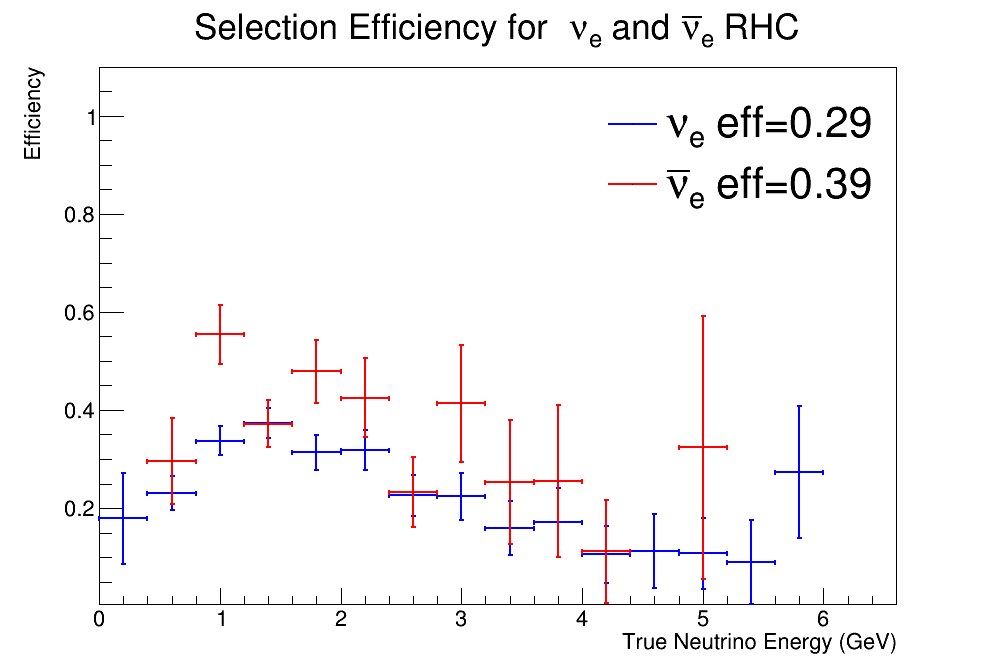

In [28]:
c_nueCut = h_nueCut.Clone()
c_nue = h_nue.Clone()

c_anueCut = h_anueCut.Clone()
c_anue = h_anue.Clone()

eff_nue = h_nueCut.Integral() / h_nue.Integral()
eff_anue = h_anueCut.Integral() / h_anue.Integral()

rebin=4
c_nueCut.Rebin(rebin)
c_nue.Rebin(rebin)
c_anueCut.Rebin(rebin)
c_anue.Rebin(rebin)

gEff_nue = r.TGraphAsymmErrors(c_nueCut, c_nue)
gEff_anue = r.TGraphAsymmErrors(c_anueCut, c_anue)

gEff_nue.SetMaximum(1.1)
gEff_nue.SetTitle("Selection Efficiency for #nu_{e} and #bar{#nu}_{e} RHC; True Neutrino Energy (GeV); Efficiency")

gEff_nue.SetLineColor(r.kBlue)
gEff_anue.SetLineColor(r.kRed)

l1 = r.TLegend(0.6, 0.68, 0.88, 0.86)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(gEff_nue, f"#nu_{{e}} eff={eff_nue:.2f}", "lp")
l1.AddEntry(gEff_anue, f"#bar{{#nu}}_{{e}} eff={eff_anue:.2f}", "lp")

gEff_nue.Draw("AP")
gEff_anue.Draw("P same")
l1.Draw()

c1.Draw()

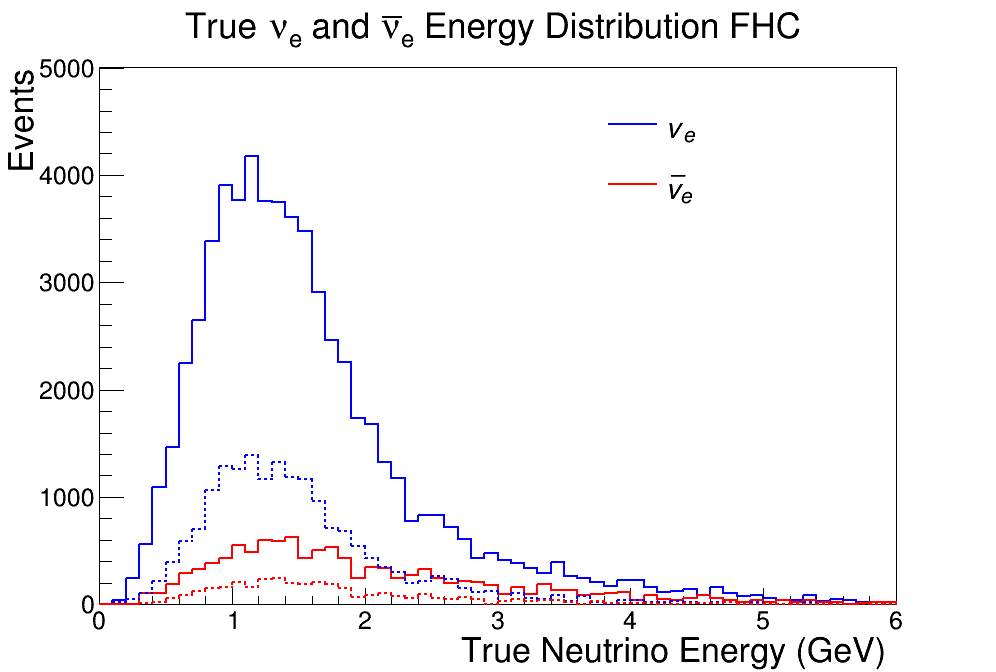

In [32]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/mcV3/mc.root")

h_nue = fin.Get("nueP/seqPlots/seqNoCut_tNueEnergy")
h_anue = fin.Get("nueA/seqPlots/seqNoCut_tNueEnergy")

# h_nueCut = fin.Get("nueP/seqPlots/seqShowerDensity_tNueEnergy")
# h_anueCut = fin.Get("nueA/seqPlots/seqShowerDensity_tNueEnergy")
h_nueCut = fin.Get("nueP/nm1Plots/nm1ShowerEnergy_tNueEnergy")
h_anueCut = fin.Get("nueA/nm1Plots/nm1ShowerEnergy_tNueEnergy")

h_nue.SetLineColor(r.kBlue)
h_nue.SetLineWidth(2)
h_anue.SetLineColor(r.kRed)
h_anue.SetLineWidth(2)

h_nueCut.SetLineColor(r.kBlue)
h_nueCut.SetLineWidth(2)
h_nueCut.SetLineStyle(2)
h_anueCut.SetLineColor(r.kRed)
h_anueCut.SetLineWidth(2)
h_anueCut.SetLineStyle(2)

max_hist = max(h_nue.GetMaximum(), h_anue.GetMaximum())
h_nue.SetMaximum(max_hist * 1.2)
h_nue.SetMinimum(0)

l1 = r.TLegend(0.6, 0.68, 0.88, 0.86)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(h_nue, r"\nu_e", "l")
l1.AddEntry(h_anue, r"\bar{\nu}_e", "l")

h_nue.SetTitle("True #nu_{e} and #bar{#nu}_{e} Energy Distribution FHC;True Neutrino Energy (GeV);Events")
h_nue.Draw("hist")
h_anue.Draw("hist same")

h_nueCut.Draw("hist same")
h_anueCut.Draw("hist same")

l1.Draw()

c1.Draw()

Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms


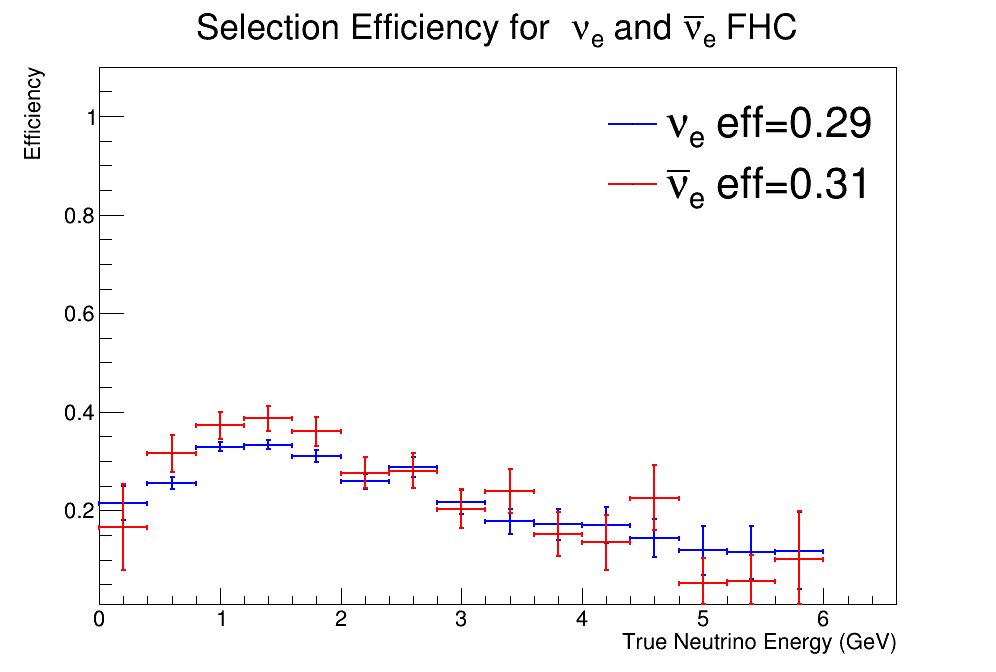

In [30]:
c_nueCut = h_nueCut.Clone()
c_nue = h_nue.Clone()

c_anueCut = h_anueCut.Clone()
c_anue = h_anue.Clone()

eff_nue = h_nueCut.Integral() / h_nue.Integral()
eff_anue = h_anueCut.Integral() / h_anue.Integral()

rebin=4
c_nueCut.Rebin(rebin)
c_nue.Rebin(rebin)
c_anueCut.Rebin(rebin)
c_anue.Rebin(rebin)

gEff_nue = r.TGraphAsymmErrors(c_nueCut, c_nue)
gEff_anue = r.TGraphAsymmErrors(c_anueCut, c_anue)

gEff_nue.SetMaximum(1.1)
gEff_nue.SetTitle("Selection Efficiency for #nu_{e} and #bar{#nu}_{e} FHC; True Neutrino Energy (GeV); Efficiency")

gEff_nue.SetLineColor(r.kBlue)
gEff_anue.SetLineColor(r.kRed)

l1 = r.TLegend(0.6, 0.68, 0.88, 0.86)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(gEff_nue, f"#nu_{{e}} eff={eff_nue:.2f}", "lp")
l1.AddEntry(gEff_anue, f"#bar{{#nu}}_{{e}} eff={eff_anue:.2f}", "lp")

gEff_nue.Draw("AP")
gEff_anue.Draw("P same")
l1.Draw()

c1.Draw()

### Check efficiency for CVN

In [145]:
fin = r.TFile.Open("/nashome/m/micarrig/icarus/NuE/nueOutputs/cvnMC/mc.root")

scale_mc = 1.0

In [146]:
s_nue = getHistList(fin, "nue/seqPlots", scale=scale_mc)
s_numu = getHistList(fin, "numu/seqPlots", scale=scale_mc)
s_nc = getHistList(fin, "nc/seqPlots", scale=scale_mc)
s_cosmic = getHistList(fin, "cosmic/seqPlots", scale=scale_mc)
s_all = getHistList(fin, "allEvents/seqPlots", skip="MaxShowerEnergySlice", scale=scale_mc)
s_trueE = getHistList(fin, "fid/seqPlots", scale=scale_mc)
s_nueEff = getHistList(fin, "nueEff/seqPlots", skip='MaxShowerEnergySlice', scale=scale_mc)


n_nue = getHistList(fin, "nue/nm1Plots", scale=scale_mc)
n_numu = getHistList(fin, "numu/nm1Plots", scale=scale_mc)
n_nc = getHistList(fin, "nc/nm1Plots", scale=scale_mc)
n_cosmic = getHistList(fin, "cosmic/nm1Plots", scale=scale_mc)
n_all = getHistList(fin, "allEvents/nm1Plots", skip="MaxShowerEnergySlice", scale=scale_mc)
n_trueE = getHistList(fin, "fid/nm1Plots", scale=scale_mc)
n_nueEff = getHistList(fin, "nueEff/nm1Plots", skip='MaxShowerEnergySlice', scale=scale_mc)

In [147]:
c1 = r.TCanvas("c1", "c1", 800, 600)
h_num = n_nueEff['nm1CVNNue_rShowerEnergy'].hist.Clone()
h_den = s_nueEff['seqNoCut_rShowerEnergy'].hist.Clone()
g_eff = r.TGraphAsymmErrors(h_num, h_den)
g_eff.SetTitle("Shower Energy Efficiency;Shower Energy (GeV);Efficiency")
g_eff.SetLineColor(r.kBlack)
g_eff.SetMarkerStyle(20)
g_eff.SetMarkerColorAlpha(r.kBlack, 0.5)
g_eff.Draw("AP")

h_num_cvn = s_nueEff['seqShowerDensity_rShowerEnergy'].hist.Clone()
h_den_cvn = s_nueEff['seqNoCut_rShowerEnergy'].hist.Clone()
g_eff_cvn = r.TGraphAsymmErrors(h_num_cvn, h_den_cvn)
g_eff_cvn.SetTitle("Shower Energy Efficiency;Shower Energy (GeV);Efficiency")
g_eff_cvn.SetLineColor(r.kRed)
g_eff_cvn.SetMarkerStyle(21)
g_eff_cvn.SetMarkerColorAlpha(r.kRed, 0.5)
g_eff_cvn.Draw("P SAME")

totalNue = s_trueE['seqNoCut_NumNuE'].integral
effCVN = s_nueEff['seqShowerDensity_rFiducial'].integral / totalNue
eff = n_nueEff['nm1CVNNue_rFiducial'].integral / totalNue

purity = n_nueEff['nm1CVNNue_rFiducial'].integral / n_all['nm1CVNNue_rFiducial'].integral
purityCVN = s_nueEff['seqShowerDensity_rFiducial'].integral / s_all['seqShowerDensity_rFiducial'].integral

print(purity, purityCVN)

l1 = r.TLegend(0.2, 0.7, 0.5, 0.9)
l1.SetBorderSize(0)
l1.SetFillStyle(0)
l1.AddEntry(g_eff_cvn, f"CVN: > 0.85, e={effCVN:.2f}, p={purityCVN:.2f}", "lp")
l1.AddEntry(g_eff, f"No CVN, e={eff:.2f}, p={purity:.2f}", "lp")
l1.Draw()

c1.Draw()

totalNue

0.4775517110693264 0.8557473039509162


79030.05065491909

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 29 points have been skipped
Warning in <TGraphAsymmErrors::Divide>: Histograms have weights: only Normal or Bayesian error calculation is supported
Info in <TGraphAsymmErrors::Divide>: Using now the Normal approximation for weighted histograms
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 29 points have been skipped


# Efficiency-based binning
#
# Adds a helper that produces initial bin edges that aim to flatten the efficiency
# (numerator / denominator) across bins. Use this when you have per-event numerator
# and denominator weights (e.g. numerator=passed, denominator=total) and want
# binning in `x` that keeps per-bin efficiency close to global efficiency.


In [249]:
import numpy as np


def initial_edges_efficiency(x, num, den, n_bins, left=None, right=None, min_width=0.0):
    """
    Compute initial bin edges in `x` that attempt to flatten efficiency = sum(num)/sum(den)
    across `n_bins` bins.

    This uses a greedy left-to-right algorithm: sort events by `x`, then accumulate
    numerator/denominator sums until the running bin's efficiency reaches the global
    (total_num/total_den) target; make a cut there and continue. The algorithm ensures
    exactly `n_bins` bins and supports weighted numerators/denominators.

    Parameters
    ----------
    x : array-like
        Variable to bin on (1D array-like).
    num : array-like
        Numerator weights per event (same length as `x`). Can be 0/1 or floats.
    den : array-like
        Denominator weights per event (same length as `x`). Usually 1.0 for each
        event in unweighted samples, or other positive weights.
    n_bins : int
        Desired number of bins.
    left, right : float or None
        Optional left and right edges to force. If None, uses min(x) and max(x).
    min_width : float
        Minimum allowed bin width (in `x` units). When accumulating a bin, the
        code will not cut before the bin width reaches min_width. This helps avoid
        tiny-width bins when x has clustering.

    Returns
    -------
    edges : ndarray, shape (n_bins+1,)
        Bin edges (left..right) where len(edges) == n_bins+1.

    Notes
    -----
    - If denominator sums in some regions are zero, those events are skipped for
      the purpose of computing efficiencies (they do not change numerator or
      denominator sums).
    - This greedy approach is simple and tends to produce bins whose per-bin
      efficiencies are close to the global efficiency. You can follow up with a
      relaxation routine if you need finer balancing.
    """
    x = np.asarray(x)
    num = np.asarray(num, dtype=float)
    den = np.asarray(den, dtype=float)
    if x.shape[0] == 0:
        raise ValueError("x is empty")
    if not (x.shape[0] == num.shape[0] == den.shape[0]):
        raise ValueError("x, num and den must have the same length")
    if n_bins < 1:
        raise ValueError("n_bins must be >= 1")

    # Optional bounds
    if left is None:
        left = float(np.nanmin(x))
    if right is None:
        right = float(np.nanmax(x))
    if right <= left:
        raise ValueError("right must be > left")

    # Select only events inside [left, right]
    mask = (x >= left) & (x <= right)
    x_sel = x[mask]
    num_sel = num[mask]
    den_sel = den[mask]

    # sort by x
    order = np.argsort(x_sel)
    x_s = x_sel[order]
    num_s = num_sel[order]
    den_s = den_sel[order]

    N = len(x_s)
    if N == 0:
        # nothing in range, return uniform edges
        return np.linspace(left, right, n_bins + 1)

    total_num = float(np.sum(num_s))
    total_den = float(np.sum(den_s))
    if total_den == 0:
        # nothing to do - return uniform edges
        return np.linspace(left, right, n_bins + 1)

    target_eff = total_num / total_den

    edges = [left]
    i = 0

    # Precompute unique x boundaries for midpoints
    # We'll use midpoints between consecutive unique x values where possible.
    uniq_x = np.concatenate(([x_s[0]], 0.5 * (x_s[:-1] + x_s[1:]), [x_s[-1]]))

    for k in range(n_bins - 1):
        remaining_bins = n_bins - k
        remaining_events = N - i
        # Ensure at least one event per remaining bin
        min_events_for_this_bin = 1
        max_j = N - (remaining_bins - 1) - 1  # inclusive index we can stop at
        if max_j < i:
            # not enough events left; force evenly spaced edges for the rest
            break

        sum_num = 0.0
        sum_den = 0.0
        j = i
        cut_j = None
        start_x = x_s[i]
        # greedy accumulation
        while j <= max_j:
            sum_num += num_s[j]
            sum_den += den_s[j]
            if sum_den > 0:
                bin_eff = sum_num / sum_den
            else:
                # undefined bin efficiency; treat as zero so we keep accumulating
                bin_eff = 0.0

            width = x_s[j] - start_x
            # stop condition: reached or exceeded target_eff and min_width satisfied
            if (bin_eff >= target_eff and (width >= min_width or j == max_j)):
                cut_j = j
                break
            j += 1

        if cut_j is None:
            # we didn't reach target before max_j, so cut at max_j
            cut_j = max_j

        # Place edge between cut_j and cut_j+1
        if cut_j + 1 < N:
            edge = 0.5 * (x_s[cut_j] + x_s[cut_j + 1])
        else:
            # last available event for cut; place edge a tiny bit above x_s[cut_j]
            edge = min(right, x_s[cut_j] + 1e-9 * max(1.0, abs(x_s[cut_j])))

        # Ensure the edge respects min_width relative to previous edge
        if edge - edges[-1] < min_width:
            edge = edges[-1] + min_width
            # make sure we don't exceed right
            edge = min(edge, right - (n_bins - k - 1) * min_width)

        edges.append(float(edge))
        # advance i to the first index after cut_j
        i = cut_j + 1
        # if not enough events left to fill remaining bins, force single-event bins later
        if i >= N:
            # no more events. fill remaining edges evenly up to right
            break

    # Final right edge
    edges.append(right)

    # If we have fewer than n_bins+1 edges (because we broke early), add evenly spaced remaining
    edges = np.array(edges, dtype=float)
    if len(edges) < n_bins + 1:
        # fill the rest with uniform splits between last edge and right
        last = edges[-1]
        need = n_bins + 1 - len(edges)
        if last < right:
            extra = np.linspace(last, right, need + 1)[1:]
        else:
            extra = np.repeat(right, need)
        edges = np.concatenate([edges, extra])

    # If we have more edges than needed (rare), compress by linear interpolation
    if len(edges) > n_bins + 1:
        edges = np.linspace(edges[0], edges[-1], n_bins + 1)

    return edges


# Example usage (simple diagnostic):
if __name__ == '__main__':
    # Synthetic example: variable x, efficiency increasing with x
    np.random.seed(1)
    N = 5000
    x = np.random.exponential(scale=1.0, size=N)
    # true p(x) is a sigmoid-like increasing function of x
    p = 0.2 + 0.6 * (1.0 / (1.0 + np.exp(- (x - 1.0))))
    den = np.ones_like(x)
    num = np.random.binomial(1, p)

    edges = initial_edges_efficiency(x, num, den, n_bins=10)
    print('edges:', edges)

    # compute per-bin efficiencies
    inds = np.digitize(x, edges) - 1
    for i in range(len(edges)-1):
        mask = inds == i
        s_num = num[mask].sum()
        s_den = den[mask].sum()
        eff = (s_num / s_den) if s_den > 0 else np.nan
        print(f'bin {i:2d}: n_events={mask.sum():4d}, eff={eff:.4f}')


edges: [9.69553877e-05 5.95424112e+00 5.99811130e+00 6.05653952e+00
 6.13034764e+00 6.27269413e+00 6.41664544e+00 6.48115888e+00
 6.54334406e+00 7.78207480e+00 8.99351735e+00]
bin  0: n_events=4991, eff=0.4841
bin  1: n_events=   1, eff=1.0000
bin  2: n_events=   1, eff=0.0000
bin  3: n_events=   1, eff=1.0000
bin  4: n_events=   1, eff=0.0000
bin  5: n_events=   1, eff=1.0000
bin  6: n_events=   1, eff=1.0000
bin  7: n_events=   1, eff=1.0000
bin  8: n_events=   1, eff=1.0000
bin  9: n_events=   0, eff=nan


## Binning from pre-binned numerator/denominator arrays

This cell provides a helper that accepts pre-binned inputs: an array of bin edges
(for the fine-grained initial partition) plus arrays `num_vals` and `den_vals`
(with length equal to the number of input bins). The function groups contiguous
input bins into exactly `n_bins` output bins such that the per-output-bin
efficiency (sum(num)/sum(den)) is approximately the global efficiency.

This is useful when you already have histogrammed numerator/denominator values
(e.g. from a fast pre-pass) and don't want to supply per-event arrays.


In [253]:
import numpy as np


def initial_edges_from_event_arrays(x_den, x_num, n_bins,
                                    left=0, right=6, min_width=0.05,
                                    weights_den=None, weights_num=None):
    """
    Build `n_bins` bin edges in `x` (returned as length n_bins+1 array) so that the
    efficiency per bin (sum(weights_num_in_bin) / sum(weights_den_in_bin)) is
    approximately the global efficiency.

    This function accepts two event-array inputs:
      - `x_den`: values for denominator events (all trials)
      - `x_num`: values for numerator events (successful trials). Typically these
        are a subset of `x_den` (same value recorded for the same event).

    The routine aggregates identical x-values (so repeated identical values are
    handled), computes per-unique-x numerator and denominator totals, then
    greedily groups adjacent unique-x cells until each output bin's efficiency
    reaches the global efficiency target. It enforces `min_width` and respects
    optional `left`/`right` bounds.

    Important assumptions and notes:
    - `x_num` elements should correspond to a subset of `x_den` values (exact
      equality). If floating point rounding prevents exact matches, consider
      pre-binning your data into small input bins and use the histogram-based
      helper instead.
    - If weights are not provided, events are counted with weight=1.
    - If total denominator weight inside [left, right] is zero the function
      returns uniform edges between left and right.

    Parameters
    ----------
    x_den, x_num : array-like
        Arrays of values (same physical variable). x_num usually a subset of x_den.
    n_bins : int
        Desired number of output bins.
    left, right : float or None
        Optional bounding edges. If None they are taken from min/max of x_den.
    min_width : float
        Minimum allowed bin width (in x units).
    weights_den, weights_num : array-like or None
        Optional per-event weights corresponding to x_den and x_num respectively.

    Returns
    -------
    edges : ndarray, shape (n_bins+1,)
        The bin edges (left to right).
    """
    x_den = np.asarray(x_den)
    x_num = np.asarray(x_num)
    if weights_den is None:
        w_den = np.ones_like(x_den, dtype=float)
    else:
        w_den = np.asarray(weights_den, dtype=float)
    if weights_num is None:
        w_num = np.ones_like(x_num, dtype=float)
    else:
        w_num = np.asarray(weights_num, dtype=float)

    if left is None:
        if x_den.size == 0:
            raise ValueError("x_den is empty and left is None")
        left = float(np.nanmin(x_den))
    if right is None:
        if x_den.size == 0:
            raise ValueError("x_den is empty and right is None")
        right = float(np.nanmax(x_den))
    if right <= left:
        raise ValueError("right must be > left")

    # Filter denominator events to [left, right]
    mask_den = (x_den >= left) & (x_den <= right)
    x_den_f = x_den[mask_den]
    w_den_f = w_den[mask_den]

    # Filter numerator events to [left, right]
    mask_num = (x_num >= left) & (x_num <= right)
    x_num_f = x_num[mask_num]
    w_num_f = w_num[mask_num]

    # If no denominator events, return uniform edges
    if x_den_f.size == 0:
        return np.linspace(left, right, n_bins + 1)

    # Build combined array and tag which entries are den vs num so we can aggregate
    # identical x values robustly (handles duplicates correctly).
    x_all = np.concatenate([x_den_f, x_num_f])
    wden_all = np.concatenate([w_den_f, np.zeros_like(w_num_f)])
    wnum_all = np.concatenate([np.zeros_like(w_den_f), w_num_f])

    order = np.argsort(x_all)
    x_s = x_all[order]
    wden_s = wden_all[order]
    wnum_s = wnum_all[order]

    # Aggregate consecutive equal x values into unique bins
    # Using exact equality; if your data has floating rounding differences, pre-bin first.
    if x_s.size == 0:
        return np.linspace(left, right, n_bins + 1)

    # find boundaries where value changes
    change = np.nonzero(np.concatenate(([1], x_s[1:] != x_s[:-1].view(x_s.dtype))))[0]
    # alternate approach to be safe: build idx of group starts
    # We'll iterate accumulating until value changes
    uniq_x = []
    uniq_den = []
    uniq_num = []
    start = 0
    N_all = x_s.size
    for i in range(1, N_all):
        if x_s[i] != x_s[i - 1]:
            uniq_x.append(x_s[start])
            uniq_den.append(np.sum(wden_s[start:i]))
            uniq_num.append(np.sum(wnum_s[start:i]))
            start = i
    # last group
    uniq_x.append(x_s[start])
    uniq_den.append(np.sum(wden_s[start:N_all]))
    uniq_num.append(np.sum(wnum_s[start:N_all]))

    uniq_x = np.asarray(uniq_x, dtype=float)
    uniq_den = np.asarray(uniq_den, dtype=float)
    uniq_num = np.asarray(uniq_num, dtype=float)

    # If no denominator mass (shouldn't happen) return uniform
    if uniq_den.sum() == 0:
        return np.linspace(left, right, n_bins + 1)

    target_eff = uniq_num.sum() / uniq_den.sum()

    edges = [left]
    i = 0
    M = uniq_x.size

    for k in range(n_bins - 1):
        remaining_bins = n_bins - k
        remaining_groups = M - i
        if remaining_groups <= 0:
            break
        max_j = M - (remaining_bins - 1) - 1
        if max_j < i:
            max_j = i

        sum_num = 0.0
        sum_den = 0.0
        j = i
        cut_j = None
        start_x = uniq_x[i]
        while j <= max_j:
            sum_num += uniq_num[j]
            sum_den += uniq_den[j]
            bin_eff = (sum_num / sum_den) if sum_den > 0 else 0.0
            width = uniq_x[j] - start_x
            if (bin_eff >= target_eff and (width >= min_width or j == max_j)):
                cut_j = j
                break
            j += 1
        if cut_j is None:
            cut_j = max_j

        # place edge between group cut_j and cut_j+1
        if cut_j + 1 < M:
            edge = 0.5 * (uniq_x[cut_j] + uniq_x[cut_j + 1])
        else:
            edge = min(right, uniq_x[cut_j] + 1e-9 * max(1.0, abs(uniq_x[cut_j])))

        # enforce min_width relative to last edge
        if edge - edges[-1] < min_width:
            edge = edges[-1] + min_width
            edge = min(edge, right - (n_bins - k - 1) * min_width)

        edges.append(float(edge))
        i = cut_j + 1
        if i >= M:
            break

    edges.append(right)
    edges = np.array(edges, dtype=float)

    # fix up if too few edges
    if len(edges) < n_bins + 1:
        last = edges[-1]
        need = n_bins + 1 - len(edges)
        if last < right:
            extra = np.linspace(last, right, need + 1)[1:]
        else:
            extra = np.repeat(right, need)
        edges = np.concatenate([edges, extra])

    if len(edges) > n_bins + 1:
        edges = np.linspace(edges[0], edges[-1], n_bins + 1)

    return edges


# Tiny demo to illustrate usage
if __name__ == '__main__':

    edges = initial_edges_from_event_arrays(e_showerNueAll, e_showerNue, n_bins=20)
    print('edges:', edges)

    # inds = np.digitize(e_showerNueAll, edges) - 1
    # for i in range(len(edges)-1):
    #     mask = inds == i
    #     s_den = mask.sum()
    #     s_num = passed[mask].sum()
    #     eff = s_num / s_den if s_den>0 else np.nan
    #     print(f'bin {i:2d}: n_den={s_den:4d}, n_num={s_num:4d}, eff={eff:.4f}')


edges: [0.         1.02149934 1.07186705 1.12227923 1.17242801 1.22254837
 1.2732082  1.32376558 1.63541037 1.68640679 1.740879   5.21028757
 5.26028757 5.31028757 5.36028757 5.41028757 5.46028757 5.52285385
 5.61076736 5.66076736 6.        ]
